# RL for Full-Car Suspension Systems

## Define the dynamic system

In [ ]:
%reset -f

import numpy as np
import gym
from gym import spaces
import numpy as np
from scipy.linalg import expm
from scipy.integrate import quad_vec
import matplotlib.pyplot as plt

def vehicle_dynamics(t, x, params, u=None, ax=0, vx=0, steering_angle=0, z_r=None, z_r_dot=None):
    """
    Calculates the time derivative of the vehicle's state vector.

    Args:
        t (float): Current time.
        x (np.ndarray): The 14-dimensional state vector.
                        x = [zs, theta, phi, zu1, zu2, zu3, zu4,
                             zs_dot, theta_dot, phi_dot, zu1_dot, zu2_dot, zu3_dot, zu4_dot]
        params (dict): A dictionary containing vehicle parameters:
                       'ms': sprung mass
                       'I_theta': pitch moment of inertia
                       'I_phi': roll moment of inertia
                       'mu': unsprung masses (list or array of 4 elements)
                       'ks': suspension stiffness
                       'cs': suspension damping
                       'kt': tire stiffness
                       'ct': tire damping
                       'lf': distance from CG to front axle
                       'lr': distance from CG to rear axle
                       'tf': half-track width of front axle
                       'tr': half-track width of rear axle
                       'h_cg': height of the CG above the ground 
        u (np.ndarray, optional): 4-element array of control inputs u1, u2, u3, u4. Defaults to [0,0,0,0].
        ax: longitudinal acceleration (e.g., from accelerating and braking)
        vx: vehicle forward speed (in m/s)
        steering_angle: steering angle (in rad)
        z_r (np.ndarray, optional): 4-element array of road displacements z_r1, z_r2, z_r3, z_r4. Defaults to [0,0,0,0].
        z_r_dot (np.ndarray, optional): 4-element array of road velocities z_r_dot1, etc. Defaults to [0,0,0,0].

    Returns:
        np.ndarray: The 14-dimensional time derivative of the state vector (x_dot).
    """

    # Unpack state variables
    zs, theta, phi, zu1, zu2, zu3, zu4, \
        zs_dot, theta_dot, phi_dot, zu1_dot, zu2_dot, zu3_dot, zu4_dot = x

    # Unpack parameters
    ms = params['ms']
    I_theta = params['I_theta']
    I_phi = params['I_phi']
    mu = params['mu']  # A list/array of [mu1, mu2, mu3, mu4]
    ks = params['ks']
    cs = params['cs']
    kt = params['kt']
    ct = params['ct']
    lf = params['lf']
    lr = params['lr']
    tf = params['tf']
    tr = params['tr']
    h_cg = params['h_cg']

    # Default control inputs and road inputs if not provided
    if u is None:
        u = np.zeros(4)
    if z_r is None:
        z_r = np.zeros(4)
    if z_r_dot is None:
        z_r_dot = np.zeros(4)

    # State derivatives - first part are simply the current velocities
    x_dot = np.zeros(14)
    x_dot[0] = zs_dot
    x_dot[1] = theta_dot
    x_dot[2] = phi_dot
    x_dot[3] = zu1_dot
    x_dot[4] = zu2_dot
    x_dot[5] = zu3_dot
    x_dot[6] = zu4_dot

    # Calculate Delta_i and Delta_dot_i
    Delta = np.array([
        -lf * theta + tf * phi,
        -lf * theta - tf * phi,
        lr * theta + tr * phi,
        lr * theta - tr * phi
    ])

    Delta_dot = np.array([
        -lf * theta_dot + tf * phi_dot,
        -lf * theta_dot - tf * phi_dot,
        lr * theta_dot + tr * phi_dot,
        lr * theta_dot - tr * phi_dot
    ])

    # Combine unsprung mass vertical positions and velocities for easier indexing
    zu = np.array([zu1, zu2, zu3, zu4])
    zu_dot = np.array([zu1_dot, zu2_dot, zu3_dot, zu4_dot])

    # Calculate F_Si (Suspension forces)
    F_Si = np.zeros(4)
    for i in range(4):
        F_Si[i] = ks * (zu[i] - zs - Delta[i]) + cs * (zu_dot[i] - zs_dot - Delta_dot[i])

    # Calculate F_Ti (Tire forces)
    F_Ti = np.zeros(4)
    for i in range(4):
        F_Ti[i] = kt * (z_r[i] - zu[i]) + ct * (z_r_dot[i] - zu_dot[i])    

    # Calculate accelerations (the second part of x_dot)

    # Sprung Mass Vertical Motion (ddot_zs)
    sum_F_S_plus_u = np.sum(F_Si + u)
    x_dot[7] = sum_F_S_plus_u / ms  # ddot_zs

    # Pitch Motion (ddot_theta)
    x_i = np.array([-lf, -lf, lr, lr])
    sum_pitch_terms = np.sum((F_Si + u) * x_i) + ms * h_cg * ax
    x_dot[8] = sum_pitch_terms / I_theta  # ddot_theta

    # Roll Motion (ddot_phi)
    y_i = np.array([tf, -tf, tr, -tr])
    ay= vx**2*np.tan(steering_angle)/(lf+lr)
    sum_roll_terms = np.sum((F_Si + u) * y_i) + ms * h_cg * ay
    x_dot[9] = sum_roll_terms / I_phi  # ddot_phi

    # Unsprung Mass (Wheel) Motion (ddot_zui)
    for i in range(4):
        x_dot[10 + i] = (F_Ti[i] - F_Si[i] - u[i]) / mu[i]  # ddot_zu1, ddot_zu2, ddot_zu3, ddot_zu4

    return x_dot


def step_rk4(x, u, params, dt, ax=0, vx=0, steering_angle=0, z_r=None, z_r_dot=None):
    f = lambda x_: vehicle_dynamics(0, x_, params, u, ax, vx, steering_angle, z_r, z_r_dot)
    k1 = f(x)
    k2 = f(x + 0.5 * dt * k1)
    k3 = f(x + 0.5 * dt * k2)
    k4 = f(x + dt * k3)
    x_next = x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return x_next



In [ ]:
params = {
    'ms': 1500.0,       # Sprung mass (kg)
    'I_theta': 2500.0,  # Pitch moment of inertia (kg*m^2)
    'I_phi': 500.0,     # Roll moment of inertia (kg*m^2)
    'mu': [50.0, 50.0, 50.0, 50.0], # Unsprung masses for each wheel (kg)
    'ks': 25000.0,      # Suspension stiffness (N/m)
    'cs': 2000.0,       # Suspension damping (N*s/m)
    'kt': 200000.0,     # Tire stiffness (N/m)
    'ct': 150.0,        # Tire damping (N*s/m)
    'lf': 1.35,         # Distance from CG to front axle (m)
    'lr': 1.35,         # Distance from CG to rear axle (m)
    'tf': 0.75,         # Half-track width of front axle (m)
    'tr': 0.75,         # Half-track width of rear axle (m)
    'h_cg': 0.55        # height of the CG above the ground (m) for a mid-size passenger vehicle
}

dt = 0.01 # time step, unit: s
t_start = 0.0
t_end = 10.0
N = int(t_end/dt)
t = np.linspace(t_start, t_end, N+1)

K_var = np.array([5000,-250,-300,1500,-300])
K = np.array([
        # z_s_dot, theta_dot, phi_dot,   z_u1, z_u2, z_u3, z_u4,   defl1,  defl2,  defl3,  defl4
        [  K_var[0],   K_var[1],   K_var[2],   K_var[3],    0.0,    0.0,    0.0,   K_var[4],     0.0,     0.0,     0.0 ],  # u1
        [  K_var[0],  -K_var[1],   K_var[2],      0.0, K_var[3],    0.0,    0.0,       0.0, K_var[4],     0.0,     0.0 ],  # u2
        [  K_var[0],   K_var[1],  -K_var[2],      0.0,    0.0, K_var[3],    0.0,       0.0,     0.0, K_var[4],     0.0 ],  # u3
        [  K_var[0],  -K_var[1],  -K_var[2],      0.0,    0.0,    0.0, K_var[3],       0.0,     0.0,     0.0, K_var[4] ],  # u4
    ])

In [ ]:
# x0 = np.zeros(14)
# x0[3] = -0.1
# # Preallocate the array to store all states: shape (N+1, 14)
# x_all = np.zeros((N + 1, len(x0)))
# x_all[0] = x0  # Set initial condition

# # Run the simulation loop
# x = x0.copy()
# for i in range(N):
#     # Assuming x = [z_s, theta, phi, z_u1, z_u2, z_u3, z_u4, ..., z_s_dot, theta_dot, ...]
#     z_s = x[0]
#     z_u = x[3:7]  # wheel vertical displacements
#     z_s_dot = x[7]
#     theta_dot = x[8]
#     phi_dot = x[9]

#     # Suspension deflections and velocities
#     suspension_deflection = z_s - z_u  # 4 values

#     # Construct feedback state y
#     y = np.concatenate(([z_s_dot],        # make scalar into 1D array
#         [theta_dot],      # scalar → [scalar]
#         [phi_dot]
#         , z_u, suspension_deflection))  # y.shape = (11,)

#     # --- Proportional control law: u = -K * y ---
#     u_ctrl = -K @ y  # shape of K should be (4, 8) if u has 4 control inputs (1 per suspension)
#     u_ctrl_clip = np.clip(u_ctrl, -3000, 3000)  # limit to ±3000 N
    
#     x = step_rk4(x, u_ctrl_clip, params, dt)
#     x_all[i + 1] = x  # Save the new state

# plt.figure(figsize=(10, 7))

# # Plot Sprung Mass Vertical Position (zs)
# plt.subplot(4, 1, 1)
# plt.plot(t, x_all[:, 0])
# plt.ylabel(r"$z_s$, Body Vertical Position [m]")
# plt.title('Vehicle Dynamics Simulation (with Control)')
# plt.grid(True)

# # Plot Pitch Angle (theta)
# plt.subplot(4, 1, 2)
# plt.plot(t, x_all[:, 1])
# plt.ylabel(r"$\theta$, Pitch Angle [rad]")
# plt.grid(True)

# # Plot Roll Angle (phi)
# plt.subplot(4, 1, 3)
# plt.plot(t, x_all[:, 2])
# plt.ylabel(r"$\phi$, Roll Angle [rad]")
# plt.grid(True)

# # Plot Unsprung Mass Vertical Positions (zu1, zu2, zu3, zu4)
# plt.subplot(4, 1, 4)
# plt.plot(t, x_all[:, 3], label='Front Left Wheel')
# plt.plot(t, x_all[:, 4], label='Front Right Wheel')
# plt.plot(t, x_all[:, 5], label='Rear Left Wheel')
# plt.plot(t, x_all[:, 6], label='Rear Right Wheel')
# plt.ylabel(r"$z_{ui}$, Wheel Positions [m]")
# plt.xlabel('Time (s)')
# plt.grid(True)
# plt.legend(loc='upper right')

# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(10, 7))

# # Plot Sprung Mass Vertical Velocity (dzs/dt)
# plt.subplot(4, 1, 1)
# plt.plot(t, x_all[:, 7])
# plt.ylabel(r"$\dot{z}_s$, Body Vertical Velocity [m/s]")
# plt.title('Vehicle Velocity Responses')
# plt.grid(True)

# # Plot Pitch Rate (dtheta/dt)
# plt.subplot(4, 1, 2)
# plt.plot(t, x_all[:, 8])
# plt.ylabel(r"$\dot{\theta}$, Pitch Rate [rad/s]")
# plt.grid(True)

# # Plot Roll Rate (dphi/dt)
# plt.subplot(4, 1, 3)
# plt.plot(t, x_all[:, 9])
# plt.ylabel(r"$\dot{\phi}$, Roll Rate [rad/s]")
# plt.grid(True)

# # Plot Unsprung Mass Vertical Velocities (dzu1/dt to dzu4/dt)
# plt.subplot(4, 1, 4)
# plt.plot(t, x_all[:, 10], label='Front Left Wheel')
# plt.plot(t, x_all[:, 11], label='Front Right Wheel')
# plt.plot(t, x_all[:, 12], label='Rear Left Wheel')
# plt.plot(t, x_all[:, 13], label='Rear Right Wheel')
# plt.ylabel(r"$\dot{z}_{ui}$, Wheel Velocities [m/s]")
# plt.xlabel('Time (s)')
# plt.grid(True)
# plt.legend(loc='upper right')

# plt.tight_layout()
# plt.show()


## Generate data for external excitations and operational conditions

In [ ]:
# # Time settings
# n = len(t)

# # 1. Acceleration trajectory (m/s^2)
# # Define phases: accelerate (0-3s), cruise (3-5s), brake (5-8s), stop (8-10s)
# a = np.zeros(n)
# a[t < 3] = 1.5                         # Accelerating
# a[(t >= 3) & (t < 5)] = 0.0            # Cruising
# a[(t >= 5) & (t < 8)] = -2.0           # Braking
# a[t >= 8] = 0.0                        # Stop

# # 2. Steering angle trajectory (rad)
# # Simulate lane change: sinusoidal steering angle from 2s to 6s
# steering_angle = np.zeros(n)
# steering_angle[(t >= 2) & (t <= 6)] = 5 * np.sin(2 * np.pi * (t[(t >= 2) & (t <= 6)] - 2))*np.pi/180

# # 3. Velocity trajectory via numerical integration
# v = np.zeros(n)
# for i in range(1, n):
#     v[i] = v[i-1] + a[i-1] * dt
#     if v[i] < 0:
#         v[i] = 0  # prevent negative velocity

# # Add small Gaussian noise to each trajectory
# np.random.seed(42)  # for reproducibility

# # Define noise levels
# accel_noise_std = 0.1       # m/s²
# velocity_noise_std = 0.2    # m/s
# steering_noise_std = 0.5*np.pi/180    # rad

# # Add noise
# a_noisy = a + np.random.normal(0, accel_noise_std, size=n)
# v_noisy = np.zeros(n)
# for i in range(1, n):
#     v_noisy[i] = v_noisy[i-1] + a_noisy[i-1] * dt
#     if v_noisy[i] < 0:
#         v_noisy[i] = 0  # prevent negative velocity
# v_noisy += np.random.normal(0, velocity_noise_std, size=n)  # add measurement noise

# steering_angle_noisy = steering_angle + np.random.normal(0, steering_noise_std, size=n)

# # Plot the noisy results
# plt.figure(figsize=(12, 8))

# plt.subplot(3, 1, 1)
# plt.plot(t, a_noisy, label='Noisy Acceleration (m/s²)')
# plt.grid()
# plt.legend()

# plt.subplot(3, 1, 2)
# plt.plot(t, v_noisy, label='Noisy Velocity (m/s)', color='orange')
# plt.grid()
# plt.legend()

# plt.subplot(3, 1, 3)
# plt.plot(t, steering_angle_noisy, label='Noisy Steering Angle (rad)', color='green')
# plt.grid()
# plt.legend()

# plt.tight_layout()
# plt.show()


In [ ]:
class DynamicSystemEnv(gym.Env):
    def __init__(self):
        # parameters
        self.params = {
            'ms': 1500.0,       # Sprung mass (kg)
            'I_theta': 2500.0,  # Pitch moment of inertia (kg*m^2)
            'I_phi': 500.0,     # Roll moment of inertia (kg*m^2)
            'mu': [50.0, 50.0, 50.0, 50.0], # Unsprung masses for each wheel (kg)
            'ks': 25000.0,      # Suspension stiffness (N/m)
            'cs': 2000.0,       # Suspension damping (N*s/m)
            'kt': 200000.0,     # Tire stiffness (N/m)
            'ct': 150.0,        # Tire damping (N*s/m)
            'lf': 1.35,         # Distance from CG to front axle (m)
            'lr': 1.35,         # Distance from CG to rear axle (m)
            'tf': 0.75,         # Half-track width of front axle (m)
            'tr': 0.75,         # Half-track width of rear axle (m)
            'h_cg': 0.55        # height of the CG above the ground (m) for a mid-size passenger vehicle
        }
        self.ks_max = 40000
        self.ks_min = 10000
        self.cs_max = 3000
        self.cs_min = 500

        self.dt = 0.01 # time step, unit: s

        # System dynamics parameters
        self.Q = np.array([[10,0,0,0], [0,1,0,0], [0,0,50,0], [0,0,0,5]])     # State cost matrix
        self.R = 0.000001                                 # Action cost
        
        # State and action spaces
        self.observation_space = spaces.Box(low=-5, high=5, shape=(14,), dtype=np.float32)
        self.action_space = spaces.Box(low=-3000, high=3000, shape=(1,), dtype=np.float32)
        
        # Initial state
        self.state = np.zeros(14)
        
        # Maximum episode steps
        self.max_steps = 1000
        self.current_step = 0

    def step(self, action, ks_normalized, cs_normalized, ax, vx, steering_angle, zr, zr_dot):

        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.params['ks'] = ks
        self.params['cs'] = cs

        # Clip action to stay within action bounds
        action = np.clip(action, self.action_space.low, self.action_space.high)
        
        # Update state based on system dynamics
        x = self.state

        x_next = step_rk4(x, action, self.params, self.dt, ax, vx, steering_angle, zr, zr_dot)

        # Assuming x = [z_s, theta, phi, z_u1, z_u2, z_u3, z_u4, ..., z_s_dot, theta_dot, ...]
        zs = x_next[0]
        pitch_angle = x_next[1]
        roll_angle = x_next[2]
        zu1 = x_next[3]
        zu2 = x_next[4]
        zu3 = x_next[5]
        zu4 = x_next[6]
        dzs = x_next[7]
        pitch_vel = x_next[8]
        roll_vel = x_next[9]
        dzu1 = x_next[10]
        dzu2 = x_next[11]
        dzu3 = x_next[12]
        dzu4 = x_next[13]
        
        az = (x_next[7]-x[7])/self.dt
        pitch_acc = (x_next[8]-x[8])/self.dt
        roll_acc = (x_next[9]-x[9])/self.dt

        # --- Comfort Index ---
        # Assume r_pitch = 1.0 m (longitude distance from CG)
        # Assume r_pitch = 0.5 m (latitude distance from CG)
        comfort_index = np.sqrt((10.0*az)**2 + (1.0*pitch_acc)**2 + (0.5*roll_acc)**2)

        # --- Handling Metrics ---
        pitch_penalty = pitch_angle**2           # squared pitch angle
        roll_penalty = roll_angle**2             # squared roll angle

        # Define reward as negative of weighted sum of penalties
        reward = -(
            comfort_index +
            pitch_penalty/0.00004 +
            roll_penalty/0.00003 +
            self.R * np.sum(action**2)/0.01
        )
        # reward = -comfort_index
        # reward = pitch_penalty/0.00004
        # reward = roll_penalty/0.00003
        # reward = self.R * np.sum(action**2)/0.01
                
        # Update state
        self.state = x_next
        
        # Check if done
        done = (self.current_step >= self.max_steps)
        self.current_step += 1
        
        return self.state, reward, done, {}
    
    def reset(self,ks_normalized,cs_normalized):
        # Reset state to initial value
        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.params['ks'] = ks
        self.params['cs'] = cs
        self.state = np.zeros(14)
        self.state[3] = -0.1
        self.current_step = 0
        return self.state
    
    def reset_origin(self,ks_normalized,cs_normalized):
        # Reset state to initial value
        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.params['ks'] = ks
        self.params['cs'] = cs
        self.state = np.zeros(14)
        self.current_step = 0
        return self.state
    
    def render(self, mode='human'):
        pass

    def close(self):
        pass

In [ ]:
env = DynamicSystemEnv()
ks = 27692.0
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs = 1906.5
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)
s = env.reset(ks_normalized,cs_normalized)
s[3] = -0.1
print(s)

x_sys = np.zeros((14,1001))
x_sys[:,0] = s
for i in range(1000):
    # Assuming x = [z_s, theta, phi, z_u1, z_u2, z_u3, z_u4, ..., z_s_dot, theta_dot, ...]
    z_s = s[0]
    z_u = s[3:7]  # wheel vertical displacements
    z_s_dot = s[7]
    theta_dot = s[8]
    phi_dot = s[9]

    # Suspension deflections and velocities
    suspension_deflection = z_s - z_u  # 4 values

    # Construct feedback state y
    y = np.concatenate(([z_s_dot],        # make scalar into 1D array
        [theta_dot],      # scalar → [scalar]
        [phi_dot]
        , z_u, suspension_deflection))  # y.shape = (11,)

    # --- Proportional control law: u = -K * y ---
    u_ctrl = -K @ y  # shape of K should be (4, 8) if u has 4 control inputs (1 per suspension)
    a = np.clip(u_ctrl, env.action_space.low, env.action_space.high)  # limit to ±3000 N
    # ax = a_noisy[i]
    # vx = v_noisy[i]
    # steering_angle = steering_angle_noisy[i]
    vx = 10.0 + np.random.normal(0, 0.5)        # Constant forward speed with noise
    ax = 0.0 + np.random.normal(0, 0.2)        # Essentially steady state
    steering_angle = 0.0 + np.random.normal(0, 0.1) # No sharp turns
    # Generate noises for zr and zr_dot
    zr = np.random.normal(loc=0.0, scale=0.001, size=4)
    zr_dot = np.random.normal(loc=0.0, scale=0.1, size=4)
    s_prime, r, done, _ = env.step(a,ks_normalized,cs_normalized,ax,vx,steering_angle,zr,zr_dot)
    x_sys[:,i+1] = s_prime
    print("Current state:[{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}], Action: [{:.3f},{:.3f},{:.3f},{:.3f}]".format(s[0],s[1],s[2],s[3],s[4],s[5],s[6],s[7],s[8],s[9],s[10],s[11],s[12],s[13],a[0],a[1],a[2],a[3]))
    print("Next state:[{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}]".format(s_prime[0],s_prime[1],s_prime[2],s_prime[3],s_prime[4],s_prime[5],s_prime[6],s_prime[7],s_prime[8],s_prime[9],s_prime[10],s_prime[11],s_prime[12],s_prime[13]))
    s = s_prime

x_sys = x_sys.T

[ 0.   0.   0.  -0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
Current state:[0.000,0.000,0.000,-0.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000], Action: [180.000,0.000,0.000,0.000]
Next state:[0.000,-0.000,0.000,-0.081,0.000,0.000,-0.000,0.008,-0.007,0.029,3.438,0.002,0.022,-0.033]
Current state:[0.000,-0.000,0.000,-0.081,0.000,0.000,-0.000,0.008,-0.007,0.029,3.438,0.002,0.022,-0.033], Action: [112.564,-29.674,-50.966,-46.819]
Next state:[0.000,-0.000,0.001,-0.039,0.000,0.000,-0.000,0.049,-0.041,0.091,4.558,0.029,0.031,0.025]
Current state:[0.000,-0.000,0.001,-0.039,0.000,0.000,-0.000,0.049,-0.041,0.091,4.558,0.029,0.031,0.025], Action: [-157.010,-207.489,-282.647,-261.219]
Next state:[0.001,-0.001,0.002,0.003,0.001,0.001,0.000,0.092,-0.079,0.246,3.730,0.071,0.094,0.037]
Current state:[0.001,-0.001,0.002,0.003,0.001,0.001,0.000,0.092,-0.079,0.246,3.730,0.071,0.094,0.037], Action: [-411.716,-367.243,-555.275,-514.196]
Next state:[0.002,-0.002,0.005,0.032,0.0

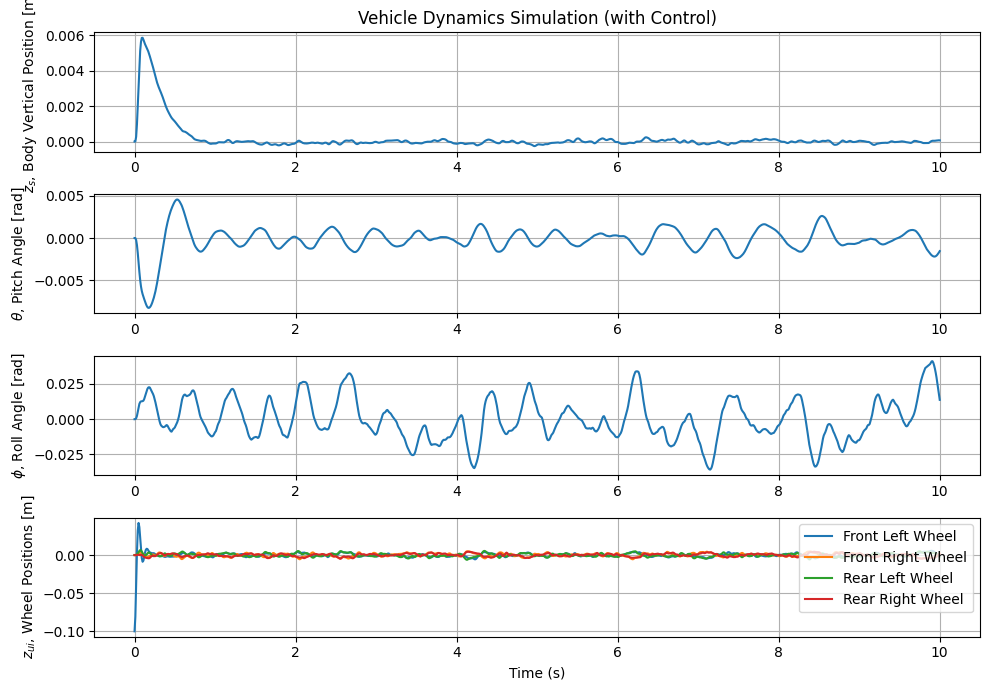

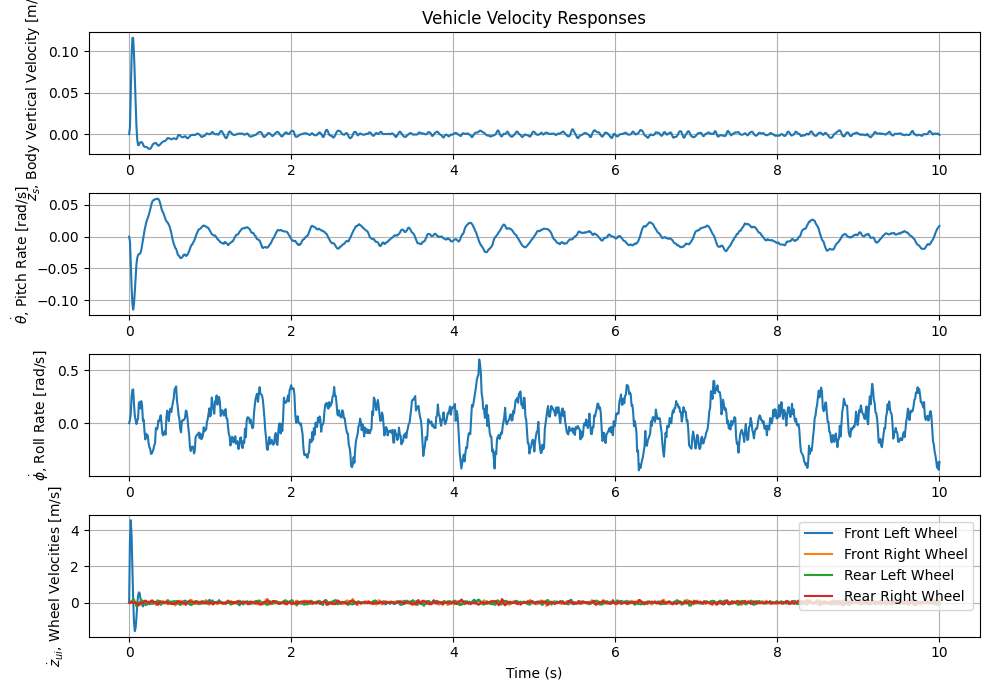

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

# Plot Sprung Mass Vertical Position (zs)
plt.subplot(4, 1, 1)
plt.plot(t, x_sys[:, 0])
plt.ylabel(r"$z_s$, Body Vertical Position [m]")
plt.title('Vehicle Dynamics Simulation (with Control)')
plt.grid(True)

# Plot Pitch Angle (theta)
plt.subplot(4, 1, 2)
plt.plot(t, x_sys[:, 1])
plt.ylabel(r"$\theta$, Pitch Angle [rad]")
plt.grid(True)

# Plot Roll Angle (phi)
plt.subplot(4, 1, 3)
plt.plot(t, x_sys[:, 2])
plt.ylabel(r"$\phi$, Roll Angle [rad]")
plt.grid(True)

# Plot Unsprung Mass Vertical Positions (zu1, zu2, zu3, zu4)
plt.subplot(4, 1, 4)
plt.plot(t, x_sys[:, 3], label='Front Left Wheel')
plt.plot(t, x_sys[:, 4], label='Front Right Wheel')
plt.plot(t, x_sys[:, 5], label='Rear Left Wheel')
plt.plot(t, x_sys[:, 6], label='Rear Right Wheel')
plt.ylabel(r"$z_{ui}$, Wheel Positions [m]")
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))

# Plot Sprung Mass Vertical Velocity (dzs/dt)
plt.subplot(4, 1, 1)
plt.plot(t, x_sys[:, 7])
plt.ylabel(r"$\dot{z}_s$, Body Vertical Velocity [m/s]")
plt.title('Vehicle Velocity Responses')
plt.grid(True)

# Plot Pitch Rate (dtheta/dt)
plt.subplot(4, 1, 2)
plt.plot(t, x_sys[:, 8])
plt.ylabel(r"$\dot{\theta}$, Pitch Rate [rad/s]")
plt.grid(True)

# Plot Roll Rate (dphi/dt)
plt.subplot(4, 1, 3)
plt.plot(t, x_sys[:, 9])
plt.ylabel(r"$\dot{\phi}$, Roll Rate [rad/s]")
plt.grid(True)

# Plot Unsprung Mass Vertical Velocities (dzu1/dt to dzu4/dt)
plt.subplot(4, 1, 4)
plt.plot(t, x_sys[:, 10], label='Front Left Wheel')
plt.plot(t, x_sys[:, 11], label='Front Right Wheel')
plt.plot(t, x_sys[:, 12], label='Rear Left Wheel')
plt.plot(t, x_sys[:, 13], label='Rear Right Wheel')
plt.ylabel(r"$\dot{z}_{ui}$, Wheel Velocities [m/s]")
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Initialize the DRL policy and value function

### Generate the state-control samples

In [ ]:
from scipy.stats import qmc

# Define number of samples and dimension
num_samples = 10000  # you can change this
dim = 16

# Create a Latin Hypercube sampler
sampler = qmc.LatinHypercube(d=dim)

# Generate samples in [0, 1]^11
samples_unit = sampler.random(n=num_samples)

# Optional: scale to your actual bounds
# Example: lower_bounds and upper_bounds are arrays 
# lower_bounds = np.array([env.ks_min,env.cs_min,-0.01,-0.5,-1,-0.05,-0.05,-0.05,-0.05,-0.06,-0.06,-0.06,-0.06])
# upper_bounds = np.array([env.ks_max,env.cs_max,0.01,0.5,1,0.05,0.05,0.05,0.05,0.06,0.06,0.06,0.06])
lower_bounds = np.array([env.ks_min,env.cs_min,-0.01,-0.1,-0.5,-0.05,-0.05,-0.05,-0.05,-0.01,-0.5,-1,-0.1,-0.1,-0.1,-0.1])
upper_bounds = np.array([env.ks_max,env.cs_max,0.01,0.1,0.5,0.05,0.05,0.05,0.05,0.01,0.5,1,0.1,0.1,0.1,0.1])
samples = qmc.scale(samples_unit, lower_bounds, upper_bounds)

# Print or use the samples
print(samples)

[[ 3.71753736e+04  2.00647419e+03 -1.88209526e-03 ... -8.16193273e-02
   4.62160794e-02  1.75716417e-02]
 [ 1.20536684e+04  1.45880405e+03 -9.88301435e-03 ... -8.17310538e-02
   8.85714085e-02  3.51763466e-02]
 [ 1.71624775e+04  6.37324066e+02  9.42674837e-03 ...  2.56535104e-02
  -3.58959994e-03 -1.81344818e-02]
 ...
 [ 2.39880559e+04  2.61421885e+03 -9.72116067e-04 ... -6.76819130e-02
  -7.88470753e-02  7.49167372e-02]
 [ 3.36740720e+04  1.31128076e+03 -4.86688752e-05 ...  9.69434922e-02
  -1.91833739e-02 -6.42994996e-02]
 [ 1.89904775e+04  2.94429889e+03  1.60584363e-03 ... -7.98987854e-02
   3.70364300e-03 -9.26529425e-02]]


In [ ]:
from autograd import jacobian
import autograd.numpy as anp

def vehicle_dynamics_autograd(t, x, params, u=None, ax=0, vx=0, steering_angle=0, z_r=None, z_r_dot=None):
    # Use autograd.numpy
    zs, theta, phi, zu1, zu2, zu3, zu4, \
        zs_dot, theta_dot, phi_dot, zu1_dot, zu2_dot, zu3_dot, zu4_dot = x

    ms = params['ms']
    I_theta = params['I_theta']
    I_phi = params['I_phi']
    mu = anp.array(params['mu'])
    ks = params['ks']
    cs = params['cs']
    kt = params['kt']
    ct = params['ct']
    lf = params['lf']
    lr = params['lr']
    tf = params['tf']
    tr = params['tr']
    h_cg = params['h_cg']

    if u is None:
        u = anp.zeros(4)
    if z_r is None:
        z_r = anp.zeros(4)
    if z_r_dot is None:
        z_r_dot = anp.zeros(4)

    x_dot = anp.zeros(14)
    x_dot = anp.concatenate([
        x[7:14],  # velocity terms: zs_dot to zu4_dot (first 7 entries)
        anp.zeros(7)  # to be filled
    ])

    Delta = anp.array([
        -lf * theta + tf * phi,
        -lf * theta - tf * phi,
        lr * theta + tr * phi,
        lr * theta - tr * phi
    ])
    Delta_dot = anp.array([
        -lf * theta_dot + tf * phi_dot,
        -lf * theta_dot - tf * phi_dot,
        lr * theta_dot + tr * phi_dot,
        lr * theta_dot - tr * phi_dot
    ])

    zu = anp.array([zu1, zu2, zu3, zu4])
    zu_dot = anp.array([zu1_dot, zu2_dot, zu3_dot, zu4_dot])

    F_Si = ks * (zu - zs - Delta) + cs * (zu_dot - zs_dot - Delta_dot)
    F_Ti = kt * (z_r - zu) + ct * (z_r_dot - zu_dot)

    x_i = anp.array([-lf, -lf, lr, lr])
    pitch_term = anp.sum((F_Si + u) * x_i) + ms * h_cg * ax

    y_i = anp.array([tf, -tf, tr, -tr])
    ay = vx ** 2 * anp.tan(steering_angle) / (lf + lr)
    roll_term = anp.sum((F_Si + u) * y_i) + ms * h_cg * ay

    x_dot = anp.concatenate([
        x[7:14],  # velocities
        anp.array([
            anp.sum(F_Si + u) / ms,
            pitch_term / I_theta,
            roll_term / I_phi,
            (F_Ti[0] - F_Si[0] - u[0]) / mu[0],
            (F_Ti[1] - F_Si[1] - u[1]) / mu[1],
            (F_Ti[2] - F_Si[2] - u[2]) / mu[2],
            (F_Ti[3] - F_Si[3] - u[3]) / mu[3]
        ])
    ])

    return x_dot

def f_aug(z,ks_normalized=0.5897,cs_normalized=0.5626):
    ks = ks_normalized*(env.ks_max-env.ks_min)+env.ks_min
    cs = cs_normalized*(env.cs_max-env.cs_min)+env.cs_min
    local_params = params.copy()
    local_params['ks'] = ks
    local_params['cs'] = cs
    x, u = z[:n], z[n:]
    return vehicle_dynamics_autograd(t, x, local_params, u)



In [ ]:
from scipy.linalg import solve_continuous_are

Q = np.diag([100,50,10,1,1,1,1,50,25,5,1,1,1,1])     # Penalizes state deviation
R = np.diag([env.R,env.R,env.R,env.R])     # Penalizes control effort
C = np.zeros((11,14))
C[0,7] = 1; C[1,8] = 1; C[2,9] = 1
C[3,3] = 1; C[4,4] = 1; C[5,5] = 1; C[6,6] = 1
C[7,0] = 1; C[7,3] = -1
C[8,0] = 1; C[8,4] = -1
C[9,0] = 1; C[9,5] = -1
C[10,0] = 1; C[10,6] = -1

N = samples.shape[0]
n = 14  # state dimension
m = 4   # control input dimension
p = 11  # output dimension (from C)

# Arrays to store results
Y_all = np.zeros((N, p))  # output y0
U_all = np.zeros((N, m))  # control u

for i in range(N):
    ks_norm = samples_unit[i, 0]
    cs_norm = samples_unit[i, 1]
    x0 = samples[i, 2:]  # 14-dim state
    u0 = np.zeros(m)

    # Update parameters for this sample
    A = jacobian(lambda z: f_aug(z, ks_norm, cs_norm)[:n])(anp.concatenate([x0, u0]))[:, :n]
    B = jacobian(lambda z: f_aug(z, ks_norm, cs_norm)[:n])(anp.concatenate([x0, u0]))[:, n:]

    # LQR Gain
    P = solve_continuous_are(A, B, Q, R)
    K = np.linalg.inv(R) @ B.T @ P

    # Compute y and u
    y0 = C @ x0
    u = -K @ x0
    action = np.clip(u, env.action_space.low, env.action_space.high)

    Y_all[i, :] = y0
    U_all[i, :] = action



In [ ]:
print(samples[:,0])

[37175.37357934 12053.66839818 17162.47750221 ... 23988.05594713
 33674.07199297 18990.47752408]


### Post-processing

In [ ]:
# Step 1: Combine the two arrays (horizontally)
combined = np.column_stack((samples[:,0], samples[:,1], Y_all))  # shape = (1000, 13)

# Step 2: Slice bounds to match combined dimension (13)
lower_bounds_y = np.array([env.ks_min,env.cs_min,-0.01,-0.5,-1,-0.05,-0.05,-0.05,-0.05,-0.06,-0.06,-0.06,-0.06])
upper_bounds_y = np.array([env.ks_max,env.cs_max,0.01,0.5,1,0.05,0.05,0.05,0.05,0.06,0.06,0.06,0.06])

# Step 3: Normalize to [0, 1] using min-max scaling
normalized_Y_all = (combined - lower_bounds_y) / (upper_bounds_y - lower_bounds_y)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

In [ ]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

try:

    # Run on single GPU

    DEVICE_ID = 0

    os.environ["CUDA_VISIBLE_DEVICES"] = str(DEVICE_ID)

    os.system("clear")

except:

    # Run on CPU

    os.system("clear")

    print("No GPU found.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# df = pd.read_csv('Data_fullcar_susp_CCD.csv')

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(13, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 4),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


Using cuda device


In [ ]:
class NeuralNetworkValue(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(13, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [ ]:
model_policy = NeuralNetwork().to(device)
model_value = NeuralNetworkValue().to(device)

In [ ]:
U_all_normalized = U_all/3000

targets = torch.tensor(U_all_normalized, dtype=torch.float32).to(device)

# Code for rescaling the variable
# U_all_rescaled = u_scaler.inverse_transform(U_all_normalized)


In [ ]:
from sklearn.model_selection import train_test_split

# Assume inputs and targets are torch tensors
X_train, X_val, y_train, y_val = train_test_split(
    normalized_Y_all, targets.cpu().numpy(), test_size=0.2, random_state=42
)

# Convert back to tensors and move to device
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val   = torch.tensor(X_val,   dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val   = torch.tensor(y_val,   dtype=torch.float32).to(device)


### Train the policy

In [ ]:
# Convert data to PyTorch tensors
inputs = torch.tensor(normalized_Y_all, dtype=torch.float32).to(device)

criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.SGD(model_policy.parameters(), lr=0.001)  # Stochastic Gradient Descent optimizer

num_epochs = 100
batch_size = 32

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    model_policy.train()
    for i in range(0, len(normalized_Y_all), batch_size):
        inputs_batch = inputs[i:i+batch_size]
        targets_batch = targets[i:i+inputs_batch.shape[0]]

        # Forward pass
        outputs = model_policy(inputs_batch)
        loss = criterion(outputs, targets_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    num_batches = int(np.ceil(len(X_train) / batch_size))
    epoch_loss /= num_batches

    # Validation
    model_policy.eval()
    with torch.no_grad():
        val_output = model_policy(X_val)
        val_loss = criterion(val_output, y_val).item()

    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f"Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch [10/100], Train Loss: 0.0330, Val Loss: 0.0257
Epoch [20/100], Train Loss: 0.0260, Val Loss: 0.0202
Epoch [30/100], Train Loss: 0.0197, Val Loss: 0.0153
Epoch [40/100], Train Loss: 0.0144, Val Loss: 0.0111
Epoch [50/100], Train Loss: 0.0100, Val Loss: 0.0077
Epoch [60/100], Train Loss: 0.0070, Val Loss: 0.0053
Epoch [70/100], Train Loss: 0.0051, Val Loss: 0.0039
Epoch [80/100], Train Loss: 0.0040, Val Loss: 0.0031
Epoch [90/100], Train Loss: 0.0035, Val Loss: 0.0027
Epoch [100/100], Train Loss: 0.0032, Val Loss: 0.0025


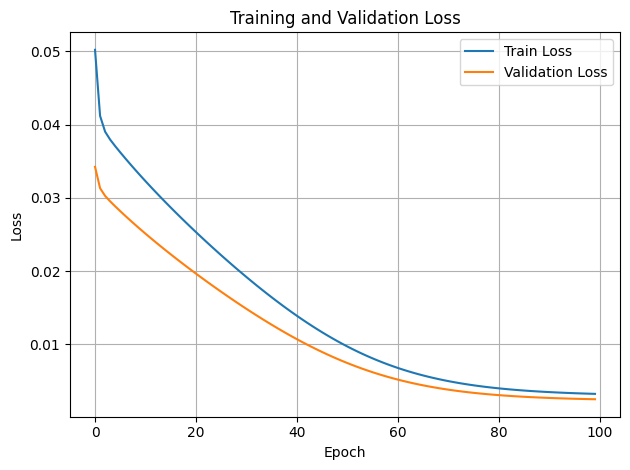

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Generate the samples for value function

In [ ]:
import numpy as np

value_samples = []
num_episodes = 10  # how many trajectories to simulate
horizon = 1000
gamma = 0.99

for i in range(N):
    # Sample physical parameters
    ks = samples[i, 0]
    cs = samples[i, 1]
    ks_normalized = (ks - env.ks_min) / (env.ks_max - env.ks_min)
    cs_normalized = (cs - env.cs_min) / (env.cs_max - env.cs_min)

    # Reset environment with the sampled parameters
    s = env.reset(ks_normalized, cs_normalized)
    s = samples[i, 2:]
    initial_state = s.copy()

    rewards = []

    for t in range(horizon):
        y = C@s
        inputs_tmp = np.array([ks,cs,y[0],y[1],y[2],y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10]])
        normalized_inputs_tmp = (inputs_tmp - lower_bounds_y) / (upper_bounds_y - lower_bounds_y)
        normalized_inputs_tmp = torch.tensor(normalized_inputs_tmp.reshape(1,13), dtype=torch.float32).to(device)
        # Run policy to get action
        u_tmp = model_policy(normalized_inputs_tmp)
        u = u_tmp.cpu().detach().numpy().flatten()*3000
        u = np.clip(u, env.action_space.low, env.action_space.high)
        vx = 10.0
        ax = 0.0
        steering_angle = 0.0
        # Generate noises for zr and zr_dot
        zr = np.random.normal(loc=0.0, scale=0.001, size=4)
        zr_dot = np.random.normal(loc=0.0, scale=0.1, size=4)
        # Step dynamics
        s_next, r, done, _ = env.step(u, ks_normalized, cs_normalized, vx, ax, steering_angle, zr, zr_dot)

        rewards.append(r)

        s = s_next

        if done:
            break

    # Compute Monte Carlo return for initial state
    G = 0
    for t, r in enumerate(rewards):
        G += (gamma ** t) * r

    # Save (state, value) pair for training value function
    value_samples.append(G)

    print(f"Sample {i+1}: Return = {G:.2f}")



Sample 1: Return = -4512.85
Sample 2: Return = -22275.58
Sample 3: Return = -14419.86
Sample 4: Return = -5928.30
Sample 5: Return = -11774.20
Sample 6: Return = -6317.76
Sample 7: Return = -6397.68
Sample 8: Return = -5657.63
Sample 9: Return = -17954.26
Sample 10: Return = -7696.00
Sample 11: Return = -4282.30
Sample 12: Return = -4249.51
Sample 13: Return = -8924.57
Sample 14: Return = -15081.97
Sample 15: Return = -10071.90
Sample 16: Return = -4317.85
Sample 17: Return = -9149.90
Sample 18: Return = -26110.71
Sample 19: Return = -9186.19
Sample 20: Return = -29609.76
Sample 21: Return = -11253.69
Sample 22: Return = -6208.08
Sample 23: Return = -30356.58
Sample 24: Return = -5684.25
Sample 25: Return = -13168.51
Sample 26: Return = -8282.77
Sample 27: Return = -4174.99
Sample 28: Return = -5481.20
Sample 29: Return = -7373.71
Sample 30: Return = -23582.07
Sample 31: Return = -12691.81
Sample 32: Return = -6572.10
Sample 33: Return = -11903.78
Sample 34: Return = -29979.89
Sample 3

In [ ]:
value_samples = np.array(value_samples).reshape(-1, 1)  # Now shape is (10000, 1)

# Combine all into one array
data_all = np.hstack((normalized_Y_all, U_all_normalized, value_samples))  # shape: (1000, 18)

# Define column names
input_cols = [f'X{i+1}' for i in range(13)]
u_cols = ['u1', 'u2', 'u3', 'u4']
columns = input_cols + u_cols + ['value']

# Create DataFrame
df = pd.DataFrame(data_all, columns=columns)

# Save to CSV
df.to_csv('dataset_FullCar_susp.csv', index=False)

In [ ]:
df = pd.read_csv('dataset_FullCar_susp.csv')
data_array = df.to_numpy()
normalized_Y_all = df[[f'X{i+1}' for i in range(13)]].to_numpy()   # Input features (13 columns)
U_all_normalized = df[['u1', 'u2', 'u3', 'u4']].to_numpy()         # Control actions (4 columns)
value_samples = df['value'].to_numpy().reshape(-1, 1)       # Value column as (N, 1)


In [ ]:
from sklearn.model_selection import train_test_split

output_data_value = value_samples/1000

# Assume inputs and targets are torch tensors
X_train, X_val, y_train, y_val = train_test_split(
    normalized_Y_all, output_data_value, test_size=0.2, random_state=42
)

# Convert back to tensors and move to device
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val   = torch.tensor(X_val,   dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val   = torch.tensor(y_val,   dtype=torch.float32).to(device)

### Train the value function

Epoch [10/100], Train Loss: 0.1486, Val Loss: 0.1037
Epoch [20/100], Train Loss: 0.0808, Val Loss: 0.0549
Epoch [30/100], Train Loss: 0.0600, Val Loss: 0.0416
Epoch [40/100], Train Loss: 0.0489, Val Loss: 0.0346
Epoch [50/100], Train Loss: 0.0420, Val Loss: 0.0302
Epoch [60/100], Train Loss: 0.0372, Val Loss: 0.0271
Epoch [70/100], Train Loss: 0.0337, Val Loss: 0.0247
Epoch [80/100], Train Loss: 0.0310, Val Loss: 0.0227
Epoch [90/100], Train Loss: 0.0287, Val Loss: 0.0210
Epoch [100/100], Train Loss: 0.0266, Val Loss: 0.0195


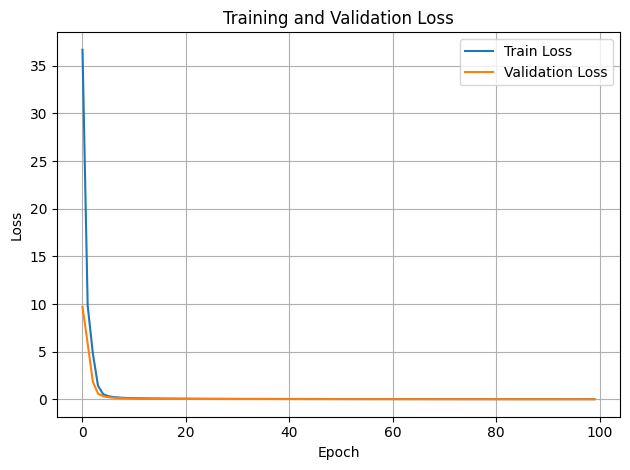

In [ ]:
# Convert data to PyTorch tensors
inputs = torch.tensor(normalized_Y_all, dtype=torch.float32).to(device)
targets = torch.tensor(output_data_value, dtype=torch.float32).to(device)

criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.SGD(model_value.parameters(), lr=0.001)  # Stochastic Gradient Descent optimizer

num_epochs = 100
batch_size = 32

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    model_value.train()
    for i in range(0, len(normalized_Y_all), batch_size):
        inputs_batch = inputs[i:i+batch_size]
        targets_batch = targets[i:i+inputs_batch.shape[0]]

        # Forward pass
        outputs = model_value(inputs_batch)
        loss = criterion(outputs, targets_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    num_batches = int(np.ceil(len(X_train) / batch_size))
    epoch_loss /= num_batches

    # Validation
    model_value.eval()
    with torch.no_grad():
        val_output = model_value(X_val)
        val_loss = criterion(val_output, y_val).item()

    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f"Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
lower_bounds = np.array([env.ks_min,env.cs_min,-0.01,-0.1,-0.5,-0.05,-0.05,-0.05,-0.05,-0.01,-0.5,-1,-0.1,-0.1,-0.1,-0.1])
upper_bounds = np.array([env.ks_max,env.cs_max,0.01,0.1,0.5,0.05,0.05,0.05,0.05,0.01,0.5,1,0.1,0.1,0.1,0.1])
lower_bounds_y = np.array([env.ks_min,env.cs_min,-0.01,-0.5,-1,-0.05,-0.05,-0.05,-0.05,-0.06,-0.06,-0.06,-0.06])
upper_bounds_y = np.array([env.ks_max,env.cs_max,0.01,0.5,1,0.05,0.05,0.05,0.05,0.06,0.06,0.06,0.06])

# Take out the weights and biases from a pretrained policy
model_policy_parameters = list(model_policy.linear_relu_stack.parameters())
model_value_parameters = list(model_value.linear_relu_stack.parameters())

lower_bounds_x_tensor = torch.tensor(lower_bounds)
upper_bounds_x_tensor = torch.tensor(upper_bounds)

lower_bounds_y_tensor = torch.tensor(lower_bounds_y)
upper_bounds_y_tensor = torch.tensor(upper_bounds_y)

In [ ]:
#Hyperparameters
learning_rate       = 0.00001
learning_rate_plant = 0.00005
gamma               = 0.99
lmbda               = 0.9
eps_clip            = 0.2
K_epoch             = 20
rollout_len         = 20
buffer_size         = 20
minibatch_size      = 64

class PPO_num(nn.Module):
    def __init__(self):
        super(PPO_num, self).__init__()
        self.data = []

        self.fc1 = nn.Linear(13, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc_mu = nn.Linear(128, 4)

        self.fc5 = nn.Linear(13, 128)
        self.fc6 = nn.Linear(128, 128)
        self.fc7 = nn.Linear(128, 128)
        self.fc_std  = nn.Linear(128, 4)

        self.fc9   = nn.Linear(13, 128)
        self.fc10  = nn.Linear(128, 128)
        self.fc11  = nn.Linear(128, 128)
        self.fc_v  = nn.Linear(128, 1)

        with torch.no_grad():
            # Weights and bias for policy function (mean)
            self.fc1.weight.copy_(model_policy_parameters[0])
            self.fc1.bias.copy_(model_policy_parameters[1])
            self.fc2.weight.copy_(model_policy_parameters[2])
            self.fc2.bias.copy_(model_policy_parameters[3])
            self.fc3.weight.copy_(model_policy_parameters[4])
            self.fc3.bias.copy_(model_policy_parameters[5])
            self.fc_mu.weight.copy_(model_policy_parameters[6])
            self.fc_mu.bias.copy_(model_policy_parameters[7])

            # Weights and bias for policy function (std)
            self.fc5.weight.copy_(torch.zeros(128, 13))
            self.fc5.bias.copy_(torch.ones(128,)*0.01)
            self.fc6.weight.copy_(torch.zeros(128, 128))
            self.fc6.bias.copy_(torch.ones(128,)*0.01)
            self.fc7.weight.copy_(torch.zeros(128, 128))
            self.fc7.bias.copy_(torch.ones(128,)*0.01)
            self.fc_std.weight.copy_(torch.zeros(128,))
            self.fc_std.bias.copy_(torch.ones(1,)*0.01)

            # Weights and bias for value function
            self.fc9.weight.copy_(model_value_parameters[0])
            self.fc9.bias.copy_(model_value_parameters[1])
            self.fc10.weight.copy_(model_value_parameters[2])
            self.fc10.bias.copy_(model_value_parameters[3])
            self.fc11.weight.copy_(model_value_parameters[4])
            self.fc11.bias.copy_(model_value_parameters[5])
            self.fc_v.weight.copy_(model_value_parameters[6])
            self.fc_v.bias.copy_(model_value_parameters[7])

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-4)
        self.optimization_step = 0
        self.optimizer_policy_update_only = optim.Adam(self.parameters(), lr=learning_rate*0.01, weight_decay=1e-4)
        self.optimization_step_policy_update_only = 0

    def pi(self, x, max_value = 0.5):
        Tanh_fuc = nn.Tanh()
        Softplus_fuc= nn.Softplus(beta=100) # To avoid negative value for std
        f1 = self.fc1(x)
        f2 = self.fc2(Tanh_fuc(f1))
        f3 = self.fc3(Tanh_fuc(f2))
        mu = self.fc_mu(Tanh_fuc(f3))
        
        f5 = self.fc5(x)
        f6 = self.fc6(Tanh_fuc(f5))
        f7 = self.fc7(Tanh_fuc(f6))
        std = torch.min(Softplus_fuc(self.fc_std(Tanh_fuc(f7))), torch.tensor(max_value))
        return mu, std
    
    def v(self, x):
        # x = F.relu(self.fc1(x))
        # v = self.fc_v(x)
        Tanh_fuc = nn.Tanh()
        f9 = self.fc9(x)
        f10 = self.fc10(Tanh_fuc(f9))
        f11 = self.fc11(Tanh_fuc(f10))
        v = self.fc_v(Tanh_fuc(f11))
        return v
      
    def put_data(self, transition):
        self.data.append(transition)

    def put_data_policy_update_only(self, rollout):
        self.data += rollout  # flatten 20-step rollout into transition list

        
    def make_batch(self):
        y_batch, a_batch, r_batch, y_prime_batch, prob_a_batch, done_batch = [], [], [], [], [], []
        data = []

        for j in range(buffer_size):
            for i in range(minibatch_size):
                rollout = self.data.pop()
                y_lst, a_lst, r_lst, y_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []

                for transition in rollout:
                    y, a, r, y_prime, prob_a, done = transition
                    
                    y_lst.append(y)
                    a_lst.append([a])
                    r_lst.append([r])
                    y_prime_lst.append(y_prime)
                    prob_a_lst.append([prob_a])
                    done_mask = 0 if done else 1
                    done_lst.append([done_mask])

                y_batch.append(y_lst)
                a_batch.append(a_lst)
                r_batch.append(r_lst)
                y_prime_batch.append(y_prime_lst)
                prob_a_batch.append(prob_a_lst)
                done_batch.append(done_lst)
                    
            mini_batch = torch.tensor(y_batch, dtype=torch.float), torch.tensor(a_batch, dtype=torch.float), \
                          torch.tensor(r_batch, dtype=torch.float), torch.tensor(y_prime_batch, dtype=torch.float), \
                          torch.tensor(prob_a_batch, dtype=torch.float), torch.tensor(done_batch, dtype=torch.float)
            data.append(mini_batch)

        return data

    def make_batch_policy_update_only(self):
        y_batch, a_batch, r_batch, y_prime_batch, prob_a_batch, done_batch = [], [], [], [], [], []

        for transition in self.data:
            # print("Total transitions in self.data:", len(self.data))
            # print("Sample transition:", self.data[0])
            # print("Transition length:", len(self.data[0]))
            y, a, r, y_prime, prob_a, done = transition
            y_batch.append(y)
            a_batch.append([a])
            r_batch.append([r])
            y_prime_batch.append(y_prime)
            prob_a_batch.append([prob_a])
            done_mask = 0 if done else 1
            done_batch.append([done_mask])

        return [(
            torch.tensor(y_batch, dtype=torch.float),
            torch.tensor(a_batch, dtype=torch.float),
            torch.tensor(r_batch, dtype=torch.float),
            torch.tensor(y_prime_batch, dtype=torch.float),
            torch.tensor(prob_a_batch, dtype=torch.float),
            torch.tensor(done_batch, dtype=torch.float)
        )]


    def calc_advantage(self, data, ks, cs):
        data_with_adv = []
        for mini_batch in data:
            y, a, r, y_prime, old_log_prob, done_mask = mini_batch
            with torch.no_grad():
                tensor_size = torch.Tensor.size(y_prime)
                new_tensor1 = torch.full((tensor_size[0],tensor_size[1],1), ks)
                new_tensor2 = torch.full((tensor_size[0],tensor_size[1],1), cs)
                # Concatenate the original tensor and the new tensor along the last dimension
                x = torch.cat((new_tensor1, new_tensor2, y), dim=2) # All input (ks,cs,y1,...,y11)
                x_normalized = (x-lower_bounds_y_tensor)/(upper_bounds_y_tensor-lower_bounds_y_tensor)
                x_normalized = x_normalized.type(torch.float32)
                x_prime = torch.cat((new_tensor1, new_tensor2, y_prime), dim=2)
                x_prime_normalized = (x_prime-lower_bounds_y_tensor)/(upper_bounds_y_tensor-lower_bounds_y_tensor)
                x_prime_normalized = x_prime_normalized.type(torch.float32)
                td_target = r + gamma * self.v(x_prime_normalized)
                delta = td_target - self.v(x_normalized)
            delta = delta.numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)
            data_with_adv.append((y, a, r, y_prime, old_log_prob, done_mask, td_target, advantage))

        return data_with_adv

    def calc_advantage_policy_update_only(self, data, ks, cs):
        data_with_adv = []
        for mini_batch in data:
            y, a, r, y_prime, old_log_prob, done_mask = mini_batch
            with torch.no_grad():
                tensor_size = torch.Tensor.size(y_prime)
                new_tensor1 = torch.full((tensor_size[0], 1), ks)
                new_tensor2 = torch.full((tensor_size[0], 1), cs)
                x = torch.cat((new_tensor1, new_tensor2, y), dim=1) # All input (ks,cs,y1,...,y11)
                x_normalized = (x-lower_bounds_y_tensor)/(upper_bounds_y_tensor-lower_bounds_y_tensor)
                x_normalized = x_normalized.type(torch.float32)
                x_prime = torch.cat((new_tensor1, new_tensor2, y_prime), dim=1)
                x_prime_normalized = (x_prime-lower_bounds_y_tensor)/(upper_bounds_y_tensor-lower_bounds_y_tensor)
                x_prime_normalized = x_prime_normalized.type(torch.float32)
                td_target = r + gamma * self.v(x_prime_normalized)
                delta = td_target - self.v(x_normalized)
            delta = delta.numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)
            data_with_adv.append((y, a, r, y_prime, old_log_prob, done_mask, td_target, advantage))

        return data_with_adv

    def train_net(self,ks,cs):
        global ks_torch, cs_torch
        ks_torch = torch.tensor(ks, requires_grad=True, dtype=torch.float32)
        cs_torch = torch.tensor(cs, requires_grad=True, dtype=torch.float32)
        # if len(self.data) == minibatch_size * buffer_size:
        if len(self.data) >= rollout_len:
            data = self.make_batch_policy_update_only()
            data = self.calc_advantage_policy_update_only(data,ks,cs)

            for i in range(K_epoch):
                for mini_batch in data:
                    y, a, r, y_prime, done_mask, old_log_prob, td_target, advantage = mini_batch
                    # compute the loss and gradient
                    tensor_size = torch.Tensor.size(y)
                    # new_tensor = torch.full((tensor_size[0],tensor_size[1],1), p_torch_in)
                    new_tensor1 = ks_torch.expand(tensor_size[0], 1)
                    new_tensor2 = cs_torch.expand(tensor_size[0], 1)
                    # Concatenate the original tensor and the new tensor along the last dimension
                    x = torch.cat((new_tensor1, new_tensor2, y), dim=1) # All input (ks,cs,y1,...,y11)
                    x_normalized = (x-lower_bounds_y_tensor)/(upper_bounds_y_tensor-lower_bounds_y_tensor)
                    x_normalized = x_normalized.type(torch.float32)
                    mu, std = self.pi(x_normalized, max_value=0.5)
                    dist = Normal(mu, std)
                    log_prob = dist.log_prob(a)
                    ratio = torch.exp(log_prob - old_log_prob)  # a/b == exp(log(a)-log(b))

                    surr1 = ratio * advantage
                    surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
                    # clamp function ensures ratio is within the range
                    loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(x_normalized) , td_target)
                    # compute the Smooth L1 loss, which is less sensitive to outliers than the MSE loss

                    self.optimizer_policy_update_only.zero_grad()
                    loss.mean().backward() # compute the gradients of the loss with respect to the model parameters
                    nn.utils.clip_grad_norm_(self.parameters(), 1.0) # clip the gradients' norm to prevent the exploding gradient problem, clipped to a maximum of 1.0 in this case
                    self.optimizer_policy_update_only.step() # update the model parameters using the gradients computed during backpropagation
                    self.optimization_step_policy_update_only += 1

            self.data = []  # Clear buffer after training
            print("Policy has been updated!")

    def train_net_CCD(self,ks,cs): # co-optimizing policy and the system parameter p
        global p_torch
        ks_torch = torch.tensor(ks, dtype=torch.float32)
        cs_torch = torch.tensor(cs, dtype=torch.float32)
        tensor_list = [(ks_torch-lower_bounds_x_tensor[0])/(upper_bounds_x_tensor[0]-lower_bounds_x_tensor[0]),(cs_torch-lower_bounds_x_tensor[1])/(upper_bounds_x_tensor[1]-lower_bounds_x_tensor[1])]
        p_torch = torch.tensor([t.item() for t in tensor_list], dtype=torch.float64, requires_grad=True) # Convert the list of tensors into a single tensor
        if len(self.data) == minibatch_size * buffer_size:
            data = self.make_batch()
            data = self.calc_advantage(data,ks,cs)
            # optimizer_p = torch.optim.SGD([p_torch], lr=0.001) # define the optimizer that only updates p
            optimizer_p = torch.optim.Adam([p_torch], lr=learning_rate_plant, weight_decay=1e-4) # define the optimizer that only updates p; 'weight_decay' can help with overfitting

            for i in range(K_epoch):
                for mini_batch in data:
                    y, a, r, y_prime, old_log_prob, done_mask, td_target, advantage = mini_batch
                    # compute the loss and gradient
                    tensor_size = torch.Tensor.size(y)
                    ks_tensor = p_torch[0] * (upper_bounds_x_tensor[0] - lower_bounds_x_tensor[0]) + lower_bounds_x_tensor[0]
                    cs_tensor = p_torch[1] * (upper_bounds_x_tensor[1] - lower_bounds_x_tensor[1]) + lower_bounds_x_tensor[1]
                    new_tensor1 = ks_tensor.expand(tensor_size[0], tensor_size[1], 1)
                    new_tensor2 = cs_tensor.expand(tensor_size[0], tensor_size[1], 1)
                    # Concatenate the original tensor and the new tensor along the last dimension
                    x = torch.cat((new_tensor1, new_tensor2, y), dim=2) # All input (ks,cs,y1,...,y11)
                    x_normalized = (x-lower_bounds_y_tensor)/(upper_bounds_y_tensor-lower_bounds_y_tensor)
                    x_normalized = x_normalized.type(torch.float32)
                    mu, std = self.pi(x_normalized, max_value=0.5)
                    dist = Normal(mu, std)
                    a = a.squeeze(dim=2)  # removes the dimension of size 1 at position 2
                    log_prob = dist.log_prob(a)
                    old_log_prob = old_log_prob.squeeze(2) 
                    # print("log_prob:", log_prob.shape)
                    # print("old_log_prob:", old_log_prob.shape)
                    ratio = torch.exp(log_prob - old_log_prob)  # a/b == exp(log(a)-log(b))

                    surr1 = ratio * advantage
                    surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
                    # clamp function ensures ratio is within the range
                    loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(x_normalized) , td_target)
                    # compute the Smooth L1 loss, which is less sensitive to outliers than the MSE loss

                    # autograd
                    optimizer_p.zero_grad()
                    loss.mean().backward(retain_graph=True) # Perform backward pass to compute gradients
                    optimizer_p.step()
                    # print(p_torch)

                    self.optimizer.zero_grad()
                    loss.mean().backward() # compute the gradients of the loss with respect to the model parameters
                    nn.utils.clip_grad_norm_(self.parameters(), 1.0) # clip the gradients' norm to prevent the exploding gradient problem, clipped to a maximum of 1.0 in this case
                    self.optimizer.step() # update the model parameters using the gradients computed during backpropagation
                    self.optimization_step += 1
            self.data = []
        return p_torch[0], p_torch[1]


In [ ]:
import copy
RLmodel_initial = PPO_num()
model = copy.deepcopy(RLmodel_initial)

## Evaluate the system with the initial policy and value function

In [ ]:
from scipy.stats import sem, t

ks = 27692.0
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs = 1906.5
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)

device = next(model.parameters()).device 

score_total = []
num_replicates = 3000
x_sys = np.zeros((num_replicates,1001,14))
y_sys = np.zeros((num_replicates,1001,11))
a_sys = np.zeros((num_replicates,1000,4))
for k in range(num_replicates):
    s = env.reset(ks_normalized, cs_normalized)
    score = 0
    x_sys[k,0,:] = np.array([s[0],s[1],s[2],s[3],s[4],s[5],s[6],s[7],s[8],s[9],s[10],s[11],s[12],s[13]])
    y = C@s
    y_sys[k,0,:] = np.array([y[0],y[1],y[2],y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10]])
    for i in range(1000):
        y = C@s
        inputs_tmp = np.array([ks,cs,y[0],y[1],y[2],y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10]])
        normalized_inputs_tmp = (inputs_tmp - lower_bounds_y) / (upper_bounds_y - lower_bounds_y)
        normalized_inputs_tmp = torch.tensor(normalized_inputs_tmp.reshape(1,13), dtype=torch.float32).to(device)
        # Run policy to get action
        mu, std = model.pi(normalized_inputs_tmp)
        dist = Normal(mu, std)
        a = dist.sample()
        log_prob = dist.log_prob(a)
        action_tmp = a.cpu().detach().numpy().flatten()*3000
        action = np.clip(action_tmp, env.action_space.low, env.action_space.high)
        # u_tmp = model_policy(normalized_inputs_tmp)
        # u = u_tmp.cpu().detach().numpy().flatten()*3000
        # action = np.clip(u, env.action_space.low, env.action_space.high)
        # ax = a_noisy[i]
        # vx = v_noisy[i]
        # steering_angle = steering_angle_noisy[i]
        # vx = 10.0 + np.random.normal(0, 0.5)        # Constant forward speed with noise
        # ax = 0.0 + np.random.normal(0, 0.2)        # Essentially steady state
        # steering_angle = 0.0 + np.random.normal(0, 0.1) # No sharp turns
        vx = 10.0
        ax = 0.0
        steering_angle = 0.0
        # Generate noises for zr and zr_dot
        zr = np.random.normal(loc=0.0, scale=0.001, size=4)
        zr_dot = np.random.normal(loc=0.0, scale=0.1, size=4)
        # Step dynamics
        s_prime, r, done, _ = env.step(action,ks_normalized,cs_normalized,ax,vx,steering_angle,zr,zr_dot)
        y_prime = C@s_prime
        rewards.append(r)

        x_sys[k,i+1,:] = s_prime
        y_sys[k,i+1,:] = y_prime
        a_sys[k,i,:] = action
        score += r
        s = s_prime
    score_total.append(score)
    print("# of episode :{}, score : {:.4f}".format(k, score))



# of episode :0, score : -2460.3846
# of episode :1, score : -2552.0037
# of episode :2, score : -2494.3511
# of episode :3, score : -2435.0170
# of episode :4, score : -2588.7200
# of episode :5, score : -2556.3661
# of episode :6, score : -2512.0504
# of episode :7, score : -2551.4589
# of episode :8, score : -2496.1789
# of episode :9, score : -2507.9745
# of episode :10, score : -2543.5195
# of episode :11, score : -2470.2732
# of episode :12, score : -2512.5385
# of episode :13, score : -2575.3336
# of episode :14, score : -2571.3979
# of episode :15, score : -2578.9808
# of episode :16, score : -2503.2550
# of episode :17, score : -2490.2558
# of episode :18, score : -2525.5383
# of episode :19, score : -2530.2298
# of episode :20, score : -2593.6425
# of episode :21, score : -2480.0058
# of episode :22, score : -2522.9196
# of episode :23, score : -2452.4171
# of episode :24, score : -2512.9616
# of episode :25, score : -2532.4771
# of episode :26, score : -2507.9628
# of episod

In [ ]:
import pickle

variables_to_save = {
    'ks': ks, # system parameter
    'cs': cs, # system parameter
    'env': env,
    'x_sys': x_sys,
    'a_sys': a_sys,
    'y_sys': y_sys,
    'score_total': score_total
    # Add more variables as needed
}


with open('Trajs_eval_sys_initial.pkl', 'wb') as file:
    pickle.dump(variables_to_save, file)


In [ ]:
# import pickle

# # Load the variables from the pickle file
# with open('data3/Trajs_eval_sys_first_opt.pkl', 'rb') as file:
#     loaded_data = pickle.load(file)

# # Extract individual variables
# ks = loaded_data['ks']
# cs = loaded_data['cs']
# env = loaded_data['env']
# x_sys = loaded_data['x_sys']
# a_sys = loaded_data['a_sys']
# y_sys = loaded_data['y_sys']
# score_total = loaded_data['score_total']

Average Score: -2525.297
Std of Score: 41.080


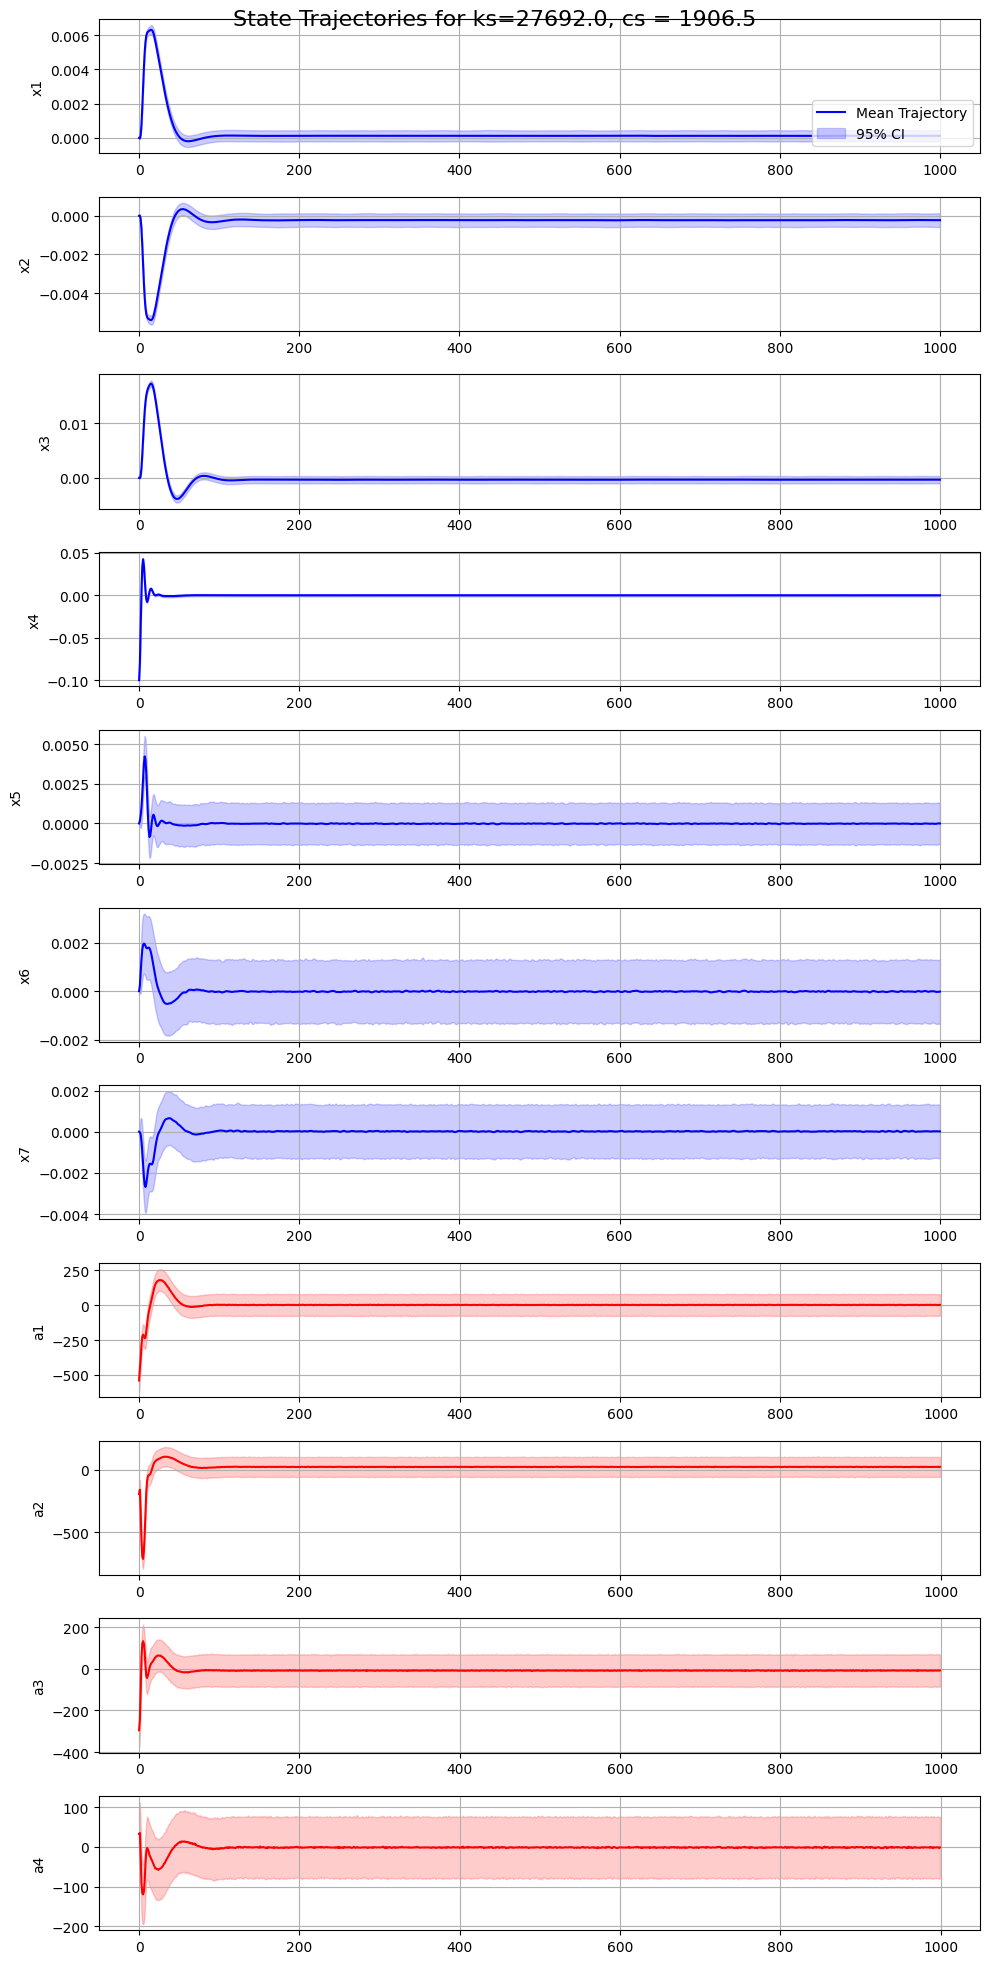

In [ ]:
from scipy.stats import sem, t

avg_score = np.average(score_total)
std_score = np.std(score_total)
print("Average Score: {:.3f}".format(avg_score))
print("Std of Score: {:.3f}".format(std_score))

# Calculate the t critical value for 95% confidence interval
confidence = 0.95
n = x_sys.shape[0]  # number of trajectories
t_critical = t.ppf((1 + confidence) / 2., n - 1)


mean_trajs = []
for i in range(x_sys.shape[2]):
    mean_trajs.append(np.mean(x_sys[:, :, i], axis=0))

mean_trajs_a = []
for i in range(a_sys.shape[2]):
    mean_trajs_a.append(np.mean(a_sys[:, :, i], axis=0))

std_trajs = []; margin_of_error = []; lower_trajs = []; upper_trajs = []
for i in range(x_sys.shape[2]):
    std_trajs.append(np.std(x_sys[:, :, i], axis=0))
    margin_of_error.append(t_critical * std_trajs[i])
    lower_trajs.append(mean_trajs[i] - margin_of_error[i])
    upper_trajs.append(mean_trajs[i] + margin_of_error[i])

std_trajs_a = []; margin_of_error_a = []; lower_trajs_a = []; upper_trajs_a = []
for i in range(a_sys.shape[2]):
    std_trajs_a.append(np.std(a_sys[:, :, i], axis=0))
    margin_of_error_a.append(t_critical * std_trajs_a[i])
    lower_trajs_a.append(mean_trajs_a[i] - margin_of_error_a[i])
    upper_trajs_a.append(mean_trajs_a[i] + margin_of_error_a[i])


t_vec = np.arange(0, 1001)

# Create the mean trajectories with 95% confidence interval
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11) = plt.subplots(11, 1, figsize=(10, 20))

ax1.plot(t_vec, mean_trajs[0], color='b', label='Mean Trajectory')
ax1.fill_between(t_vec, lower_trajs[0], upper_trajs[0], color='b', alpha=0.2, label="95% CI")
ax1.set_ylabel('x1')
# ax1.set_ylim((-3.75,1.0))
ax1.legend(loc='lower right')
ax1.grid(True)
ax1.legend(loc='lower right')


ax2.plot(t_vec, mean_trajs[1], color='b')
ax2.fill_between(t_vec, lower_trajs[1], upper_trajs[1], color='b', alpha=0.2)
ax2.set_ylabel('x2')
# ax2.set_ylim((-4,2))
ax2.grid(True)

ax3.plot(t_vec, mean_trajs[2], color='b')
ax3.fill_between(t_vec, lower_trajs[2], upper_trajs[2], color='b', alpha=0.2)
ax3.set_ylabel('x3')
# ax3.set_ylim((-4,2))
ax3.grid(True)

ax4.plot(t_vec, mean_trajs[3], color='b')
ax4.fill_between(t_vec, lower_trajs[3], upper_trajs[3], color='b', alpha=0.2)
ax4.set_ylabel('x4')
# ax4.set_ylim((-0.6,1.55))
ax4.grid(True)

ax5.plot(t_vec, mean_trajs[4], color='b')
ax5.fill_between(t_vec, lower_trajs[4], upper_trajs[4], color='b', alpha=0.2)
ax5.set_ylabel('x5')
# ax5.set_ylim((-0.6,1.55))
ax5.grid(True)

ax6.plot(t_vec, mean_trajs[5], color='b')
ax6.fill_between(t_vec, lower_trajs[5], upper_trajs[5], color='b', alpha=0.2)
ax6.set_ylabel('x6')
# ax6.set_ylim((-0.6,1.55))
ax6.grid(True)

ax7.plot(t_vec, mean_trajs[6], color='b')
ax7.fill_between(t_vec, lower_trajs[6], upper_trajs[6], color='b', alpha=0.2)
ax7.set_ylabel('x7')
# ax7.set_ylim((-0.6,1.55))
ax7.grid(True)

ax8.plot(t_vec[:-1], mean_trajs_a[0], color='r')
ax8.fill_between(t_vec[:-1], lower_trajs_a[0], upper_trajs_a[0], color='r', alpha=0.2)
ax8.set_ylabel('a1')
# ax8.set_ylim((-0.6,1.55))
ax8.grid(True)

ax9.plot(t_vec[:-1], mean_trajs_a[1], color='r')
ax9.fill_between(t_vec[:-1], lower_trajs_a[1], upper_trajs_a[1], color='r', alpha=0.2)
ax9.set_ylabel('a2')
# ax9.set_ylim((-0.6,1.55))
ax9.grid(True)

ax10.plot(t_vec[:-1], mean_trajs_a[2], color='r')
ax10.fill_between(t_vec[:-1], lower_trajs_a[2], upper_trajs_a[2], color='r', alpha=0.2)
ax10.set_ylabel('a3')
# ax10.set_ylim((-0.6,1.55))
ax10.grid(True)

ax11.plot(t_vec[:-1], mean_trajs_a[3], color='r')
ax11.fill_between(t_vec[:-1], lower_trajs_a[3], upper_trajs_a[3], color='r', alpha=0.2)
ax11.set_ylabel('a4')
# ax11.set_ylim((-0.6,1.55))
ax11.grid(True)


plt.suptitle('State Trajectories for ks='+'{0:.1f}'.format(ks)+', cs = '+'{0:.1f}'.format(cs), fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Save main state trajectories (x1 to x7) and their confidence intervals
traj_data = {
    't': t_vec
}
for i in range(7):
    traj_data[f'mean_x{i+1}'] = mean_trajs[i]
    traj_data[f'lower_x{i+1}'] = lower_trajs[i]
    traj_data[f'upper_x{i+1}'] = upper_trajs[i]

df_traj = pd.DataFrame(traj_data)
df_traj.to_csv('state_trajs_initial.csv', index=False)


# Save control trajectories (a1 to a4) and their confidence intervals
traj_a_data = {
    't': t_vec[:-1]  # actions usually one step shorter
}
for i in range(4):
    traj_a_data[f'mean_a{i+1}'] = mean_trajs_a[i]
    traj_a_data[f'lower_a{i+1}'] = lower_trajs_a[i]
    traj_a_data[f'upper_a{i+1}'] = upper_trajs_a[i]

df_traj_a = pd.DataFrame(traj_a_data)
df_traj_a.to_csv('control_trajs_initial.csv', index=False)


In [ ]:
ks = 27692.0
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs = 1906.5
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)
print_interval = 10
rollout = []
score_total = 0.0
score_history = []
ks_history = []
cs_history = []
patience = 200
threshold = 0.01  # Minimum improvement considered significant
best_reward = -float('inf')  # Initialize best reward
no_improvement_count = 0  # Counter for no improvement
print("Starting at ks = {:.4f}, cs = {:.4f}".format(ks, cs))
for n_epi in range(10000):
    s = env.reset(ks_normalized,cs_normalized)
    # print("ks = {:.4f}, cs = {:.4f}".format(ks, cs))
    done = False
    count = 0
    score = 0.0
    while count < 1000:
        for t in range(rollout_len):
            y = C@s
            y_tmp = np.append(cs,y)
            y_tmp = np.append(ks,y_tmp)
            y_normalized = (y - lower_bounds_y[2:]) / (upper_bounds_y[2:] - lower_bounds_y[2:]) # only observed states
            x = (y_tmp - lower_bounds_y) / (upper_bounds_y - lower_bounds_y) # all input (ks,cs,y1,...,y11)
            normalized_inputs_tmp = torch.tensor(x.reshape(1,13), dtype=torch.float32)
            # print(normalized_inputs_tmp)
            mu, std = model.pi(normalized_inputs_tmp)
            dist = Normal(mu, std)
            a = dist.sample()
            log_prob = dist.log_prob(a)
            action_tmp = a.cpu().detach().numpy().flatten()*3000
            action = np.clip(action_tmp, env.action_space.low, env.action_space.high)
            # s_prime, r, done, _ = env.step(action,ks_normalized,cs_normalized)
            # ax = a_noisy[i]
            # vx = v_noisy[i]
            # steering_angle = steering_angle_noisy[i]
            # vx = 10.0 + np.random.normal(0, 0.5)        # Constant forward speed with noise
            # ax = 0.0 + np.random.normal(0, 0.2)        # Essentially steady state
            # steering_angle = 0.0 + np.random.normal(0, 0.1) # No sharp turns
            vx = 10.0
            ax = 0.0
            steering_angle = 0.0
            # Generate noises for zr and zr_dot
            zr = np.random.normal(loc=0.0, scale=0.001, size=4)
            zr_dot = np.random.normal(loc=0.0, scale=0.1, size=4)
            s_prime, r, done, _ = env.step(action,ks_normalized,cs_normalized,ax,vx,steering_angle,zr,zr_dot)
            y_prime = C@s_prime
            # print("State: {}, Action = {}, Next State = {}".format(y, action, y_prime))
            y_prime_normalized = (y_prime - lower_bounds_y[2:]) / (upper_bounds_y[2:] - lower_bounds_y[2:])
            rollout.append((y, action/3000, r/1000.0, y_prime, log_prob.cpu().detach().numpy().flatten(), done))
            if len(rollout) == rollout_len:
                model.put_data(rollout)
                rollout = []

            s = s_prime

            score += r
            count += 1

        ks_torch_new, cs_torch_new = model.train_net_CCD(ks,cs)
        ks_normalized_ccd = ks_torch_new.item()
        cs_normalized_ccd = cs_torch_new.item()
        
        ks = ks_normalized_ccd*(env.ks_max-env.ks_min) + env.ks_min
        cs = cs_normalized_ccd*(env.cs_max-env.cs_min) + env.cs_min
        
        ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
        cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)

    score_total = score_total+score
    score_history.append([n_epi,score])
    ks_history.append([n_epi,ks])
    cs_history.append([n_epi,cs])

    # print("# of episode :{}, score : {:.1f}, ks = {:.4f}, cs = {:.4f}".format(n_epi, score, ks, cs))

    if n_epi%print_interval==0 and n_epi!=0:
        if n_epi==10:
            avg_score = score_total/(print_interval+1)
            print("# of episode :{}, avg score : {:.1f}, ks = {:.4f}, cs = {:.4f}".format(n_epi, avg_score, ks, cs))
        else:
            avg_score = score_total/print_interval
            print("# of episode :{}, avg score : {:.1f}, ks = {:.4f}, cs = {:.4f}".format(n_epi, avg_score, ks, cs))
        score_total = 0.0

        # Check if we have improved
        if avg_score > best_reward + threshold:
            best_reward = avg_score
            no_improvement_count = 0  # Reset the counter

            # Save the best model so far
            torch.save({
                'model_state_dict': model.state_dict(),
                'ks': ks,
                'cs': cs,
            }, 'best_policy_model.pt')
            print(f"New best model saved at epoch {n_epi}, reward: {best_reward:.4f}")
        else:
            no_improvement_count += 1

        # Early stopping check
        if no_improvement_count >= patience:
            print(f"Early stopping triggered at epoch {n_epi} with reward {avg_score}")
            break

env.close()
print("The final ks = {:.4f}".format(ks)+', cs = {:.4f}'.format(cs))

model_retrain = copy.deepcopy(model) # save the model (for back up)

Starting at ks = 27692.0000, cs = 1906.5000
# of episode :10, avg score : -2513.6, ks = 27692.0000, cs = 1906.5000
New best model saved at epoch 10, reward: -2513.5744
# of episode :20, avg score : -2546.8, ks = 27692.0000, cs = 1906.5000


/tmp/ipykernel_2636300/2976921633.py:126: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  mini_batch = torch.tensor(y_batch, dtype=torch.float), torch.tensor(a_batch, dtype=torch.float), \


# of episode :30, avg score : -2491.2, ks = 27648.8770, cs = 1916.6375
New best model saved at epoch 30, reward: -2491.2215
# of episode :40, avg score : -2481.4, ks = 27648.8770, cs = 1916.6375
New best model saved at epoch 40, reward: -2481.4331
# of episode :50, avg score : -2489.9, ks = 27648.8770, cs = 1916.6375
# of episode :60, avg score : -2364.5, ks = 27630.8145, cs = 1915.6746
New best model saved at epoch 60, reward: -2364.5107
# of episode :70, avg score : -2368.7, ks = 27630.8145, cs = 1915.6746
# of episode :80, avg score : -2345.3, ks = 27608.8203, cs = 1938.9558
New best model saved at epoch 80, reward: -2345.3349
# of episode :90, avg score : -2339.5, ks = 27608.8203, cs = 1938.9558
New best model saved at epoch 90, reward: -2339.4579
# of episode :100, avg score : -2312.3, ks = 27608.8203, cs = 1938.9558
New best model saved at epoch 100, reward: -2312.3363
# of episode :110, avg score : -2278.6, ks = 27607.6152, cs = 1923.0693
New best model saved at epoch 110, rewar

In [ ]:
# Load the saved model
checkpoint = torch.load('best_policy_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
ks = checkpoint['ks']
cs = checkpoint['cs']
model.eval()

/tmp/ipykernel_2636300/1664537194.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_policy_model.pt')


PPO_num(
  (fc1): Linear(in_features=13, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=4, bias=True)
  (fc5): Linear(in_features=13, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=128, bias=True)
  (fc_std): Linear(in_features=128, out_features=4, bias=True)
  (fc9): Linear(in_features=13, out_features=128, bias=True)
  (fc10): Linear(in_features=128, out_features=128, bias=True)
  (fc11): Linear(in_features=128, out_features=128, bias=True)
  (fc_v): Linear(in_features=128, out_features=1, bias=True)
)

## Save the trained policy

In [ ]:
import pickle

variables_to_save = {
    'model': model, # RL model after a generation (updated policy and value) and will be used for update
    # 'model_retrain': model_retrain, # RL model
    'ks': ks, # system parameter
    'cs': cs, # system parameter
    'env': env,
    'ks_history': ks_history,
    'cs_history': cs_history,
    'score_history': score_history,
    # Add more variables as needed
}

with open('FullCar_susp_CCD_first_optimization_data.pkl', 'wb') as file:
    pickle.dump(variables_to_save, file)

In [ ]:
# import pickle

# # Load the dictionary of saved variables
# with open('FullCar_susp_CCD_first_optimization_data.pkl', 'rb') as file:
#     loaded_data = pickle.load(file)

# # Unpack variables if needed
# model = loaded_data['model']
# ks = loaded_data['ks']
# cs = loaded_data['cs']
# env = loaded_data['env']
# ks_history = loaded_data['ks_history']
# cs_history = loaded_data['cs_history']
# score_history = loaded_data['score_history']



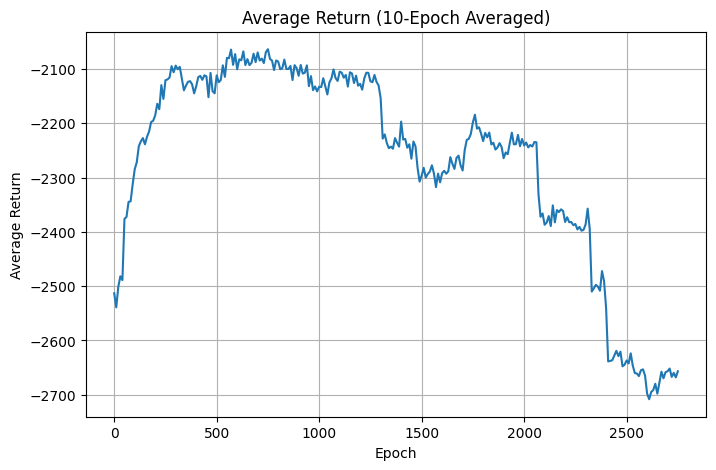

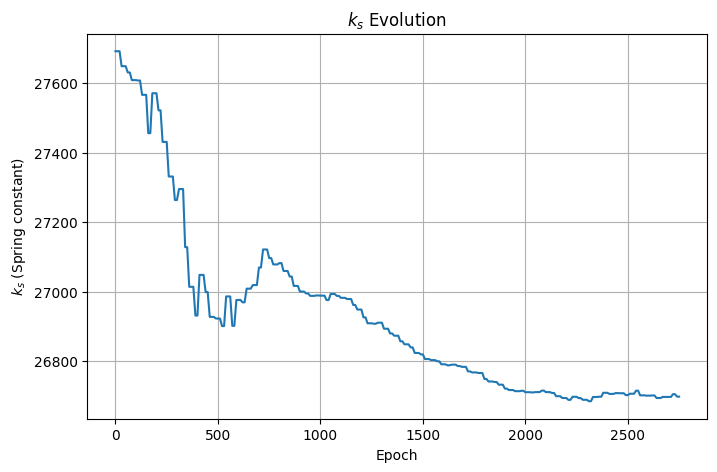

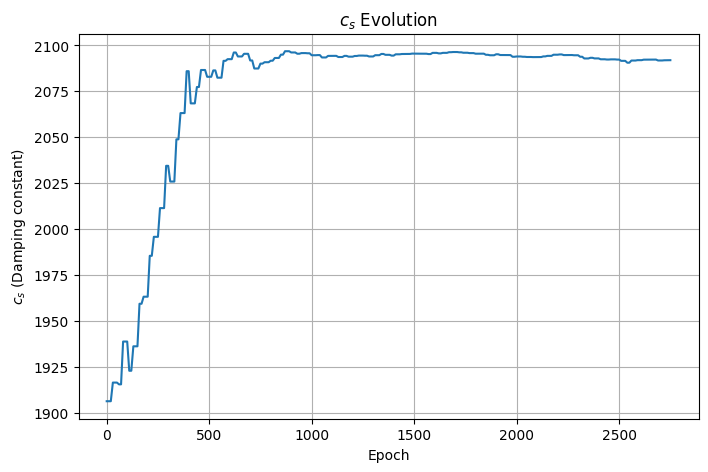

In [ ]:
# import matplotlib.pyplot as plt

# score_history_array = np.array(score_history).T
# epoch = score_history_array[0,:]
# score_history_array = score_history_array[1,:]
# score_history_avg = score_history_array.reshape(-1, 10).mean(axis=1)

# ks_history_array = np.array(ks_history).T
# ks_history_array = ks_history_array[1,:]
# cs_history_array = np.array(cs_history).T
# cs_history_array = cs_history_array[1,:]

# plt.figure(figsize=(8, 5))
# plt.plot(epoch[::10], score_history_avg)
# plt.xlabel('Epoch')
# plt.ylabel('Average Return')
# plt.show()

# plt.figure(figsize=(8, 5))
# plt.plot(epoch[::10], ks_history_array[::10])
# plt.xlabel('Epoch')
# plt.ylabel('$k_s$ (Spring constant)')
# plt.show()

# plt.figure(figsize=(8, 5))
# plt.plot(epoch[::10], cs_history_array[::10])
# plt.xlabel('Epoch')
# plt.ylabel('$c_s$ (Damping constant)')
# plt.show()

import matplotlib.pyplot as plt
import numpy as np

# --- Process score history ---
score_history_array = np.array(score_history).T
epoch = score_history_array[0, :]
score_values = score_history_array[1, :]

# Trim to make divisible by 10
n = len(score_values)
trimmed_n = n - (n % 10)
score_values_trimmed = score_values[:trimmed_n]
epoch_trimmed = epoch[:trimmed_n]

# Compute 10-epoch averaged return
score_history_avg = score_values_trimmed.reshape(-1, 10).mean(axis=1)
epoch_avg = epoch_trimmed[::10]

# --- Process spring and damping history ---
ks_history_array = np.array(ks_history).T[1, :]
cs_history_array = np.array(cs_history).T[1, :]

# Plot 1: Average Return
plt.figure(figsize=(8, 5))
plt.plot(epoch_avg, score_history_avg)
plt.xlabel('Epoch')
plt.ylabel('Average Return')
plt.title('Average Return (10-Epoch Averaged)')
plt.grid(True)
plt.show()

# Plot 2: Spring constant
plt.figure(figsize=(8, 5))
plt.plot(epoch_trimmed[::10], ks_history_array[:trimmed_n:10])
plt.xlabel('Epoch')
plt.ylabel('$k_s$ (Spring constant)')
plt.title('$k_s$ Evolution')
plt.grid(True)
plt.show()

# Plot 3: Damping constant
plt.figure(figsize=(8, 5))
plt.plot(epoch_trimmed[::10], cs_history_array[:trimmed_n:10])
plt.xlabel('Epoch')
plt.ylabel('$c_s$ (Damping constant)')
plt.title('$c_s$ Evolution')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Ensure numpy arrays
score_history_array = np.array(score_history).T
ks_history_array = np.array(ks_history).T
cs_history_array = np.array(cs_history).T

# Combine into a single DataFrame
df = pd.DataFrame({
    'Epoch': score_history_array[0, :],
    'Return': score_history_array[1, :],
    'ks': ks_history_array[1, :],
    'cs': cs_history_array[1, :]
})

# Save to CSV
df.to_csv('rl_training_results_FullCar_susp_CCD_first_opt.csv', index=False)


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Convert and preprocess
# score_history_array = np.array(score_history).T
# epoch = score_history_array[0, :]
# score_history_array = score_history_array[1, :]
# score_history_avg = score_history_array.reshape(-1, 10).mean(axis=1)

# ks_history_array = np.array(ks_history).T
# ks_history_array = ks_history_array[1, :]
# cs_history_array = np.array(cs_history).T
# cs_history_array = cs_history_array[1, :]

# # Choose how many epochs to show (e.g., up to 30,000)
# max_epoch = 30000
# mask = epoch <= max_epoch

# # For average return, slice score_history_avg and epoch[::10]
# plot_range = int(max_epoch / 10)

# # Generate plots with dynamic titles
# plt.figure(figsize=(8, 5))
# plt.plot(epoch[::10][:plot_range], score_history_avg[:plot_range])
# plt.xlabel('Epoch')
# plt.ylabel('Average Return')
# plt.title(f'Average Return (First {max_epoch:,} Epochs)')
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(8, 5))
# plt.plot(epoch[::10][:plot_range], ks_history_array[::10][:plot_range])
# plt.xlabel('Epoch')
# plt.ylabel('$k_s$ (Spring constant)')
# plt.title(f'$k_s$ Evolution (First {max_epoch:,} Epochs)')
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(8, 5))
# plt.plot(epoch[::10][:plot_range], cs_history_array[::10][:plot_range])
# plt.xlabel('Epoch')
# plt.ylabel('$c_s$ (Damping constant)')
# plt.title(f'$c_s$ Evolution (First {max_epoch:,} Epochs)')
# plt.grid(True)
# plt.show()


In [ ]:
from scipy.stats import sem, t

device = next(model.parameters()).device 

score_total = []
num_replicates = 3000
x_sys = np.zeros((num_replicates,1001,14))
y_sys = np.zeros((num_replicates,1001,11))
a_sys = np.zeros((num_replicates,1000,4))
for k in range(num_replicates):
    s = env.reset(ks_normalized, cs_normalized)
    score = 0
    x_sys[k,0,:] = np.array([s[0],s[1],s[2],s[3],s[4],s[5],s[6],s[7],s[8],s[9],s[10],s[11],s[12],s[13]])
    y = C@s
    y_sys[k,0,:] = np.array([y[0],y[1],y[2],y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10]])
    for i in range(1000):
        y = C@s
        inputs_tmp = np.array([ks,cs,y[0],y[1],y[2],y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10]])
        normalized_inputs_tmp = (inputs_tmp - lower_bounds_y) / (upper_bounds_y - lower_bounds_y)
        normalized_inputs_tmp = torch.tensor(normalized_inputs_tmp.reshape(1,13), dtype=torch.float32).to(device)
        # Run policy to get action
        mu, std = model.pi(normalized_inputs_tmp)
        dist = Normal(mu, std)
        a = dist.sample()
        log_prob = dist.log_prob(a)
        action_tmp = a.cpu().detach().numpy().flatten()*3000
        action = np.clip(action_tmp, env.action_space.low, env.action_space.high)
        # u_tmp = model_policy(normalized_inputs_tmp)
        # u = u_tmp.cpu().detach().numpy().flatten()*3000
        # action = np.clip(u, env.action_space.low, env.action_space.high)
        # ax = a_noisy[i]
        # vx = v_noisy[i]
        # steering_angle = steering_angle_noisy[i]
        # vx = 10.0 + np.random.normal(0, 0.5)        # Constant forward speed with noise
        # ax = 0.0 + np.random.normal(0, 0.2)        # Essentially steady state
        # steering_angle = 0.0 + np.random.normal(0, 0.1) # No sharp turns
        vx = 10.0
        ax = 0.0
        steering_angle = 0.0
        # Generate noises for zr and zr_dot
        zr = np.random.normal(loc=0.0, scale=0.001, size=4)
        zr_dot = np.random.normal(loc=0.0, scale=0.1, size=4)
        # Step dynamics
        s_prime, r, done, _ = env.step(action,ks_normalized,cs_normalized,ax,vx,steering_angle,zr,zr_dot)
        y_prime = C@s_prime
        rewards.append(r)

        x_sys[k,i+1,:] = s_prime
        y_sys[k,i+1,:] = y_prime
        a_sys[k,i,:] = action
        score += r
        s = s_prime
    score_total.append(score)
    print("# of episode :{}, score : {:.4f}".format(k, score))



# of episode :0, score : -2120.6129
# of episode :1, score : -2088.0295
# of episode :2, score : -2109.3461
# of episode :3, score : -2088.8284
# of episode :4, score : -2126.2781
# of episode :5, score : -2091.9608
# of episode :6, score : -2104.7017
# of episode :7, score : -2217.7514
# of episode :8, score : -2096.4834
# of episode :9, score : -2120.5899
# of episode :10, score : -2103.0055
# of episode :11, score : -2064.0197
# of episode :12, score : -2101.4748
# of episode :13, score : -2112.3723
# of episode :14, score : -2098.2836
# of episode :15, score : -2151.6432
# of episode :16, score : -2066.5813
# of episode :17, score : -2075.0905
# of episode :18, score : -2015.5487
# of episode :19, score : -2076.9342
# of episode :20, score : -2050.4952
# of episode :21, score : -2100.3638
# of episode :22, score : -2129.3281
# of episode :23, score : -2070.7379
# of episode :24, score : -2133.4194
# of episode :25, score : -2100.0993
# of episode :26, score : -2153.1523
# of episod

In [ ]:
import pickle

variables_to_save = {
    'ks': ks, # system parameter
    'cs': cs, # system parameter
    'env': env,
    'x_sys': x_sys,
    'a_sys': a_sys,
    'y_sys': y_sys,
    'score_total': score_total
    # Add more variables as needed
}


with open('Trajs_eval_sys_first_opt.pkl', 'wb') as file:
    pickle.dump(variables_to_save, file)

In [ ]:
# # Load the variables from the pickle file
# with open('data3/Trajs_eval_sys_first_opt.pkl', 'rb') as file:
#     loaded_data = pickle.load(file)

# # Extract individual variables
# ks = loaded_data['ks']
# cs = loaded_data['cs']
# env = loaded_data['env']
# x_sys = loaded_data['x_sys']
# a_sys = loaded_data['a_sys']
# y_sys = loaded_data['y_sys']
# score_total = loaded_data['score_total']

Average Score: -2091.929
Std of Score: 36.031


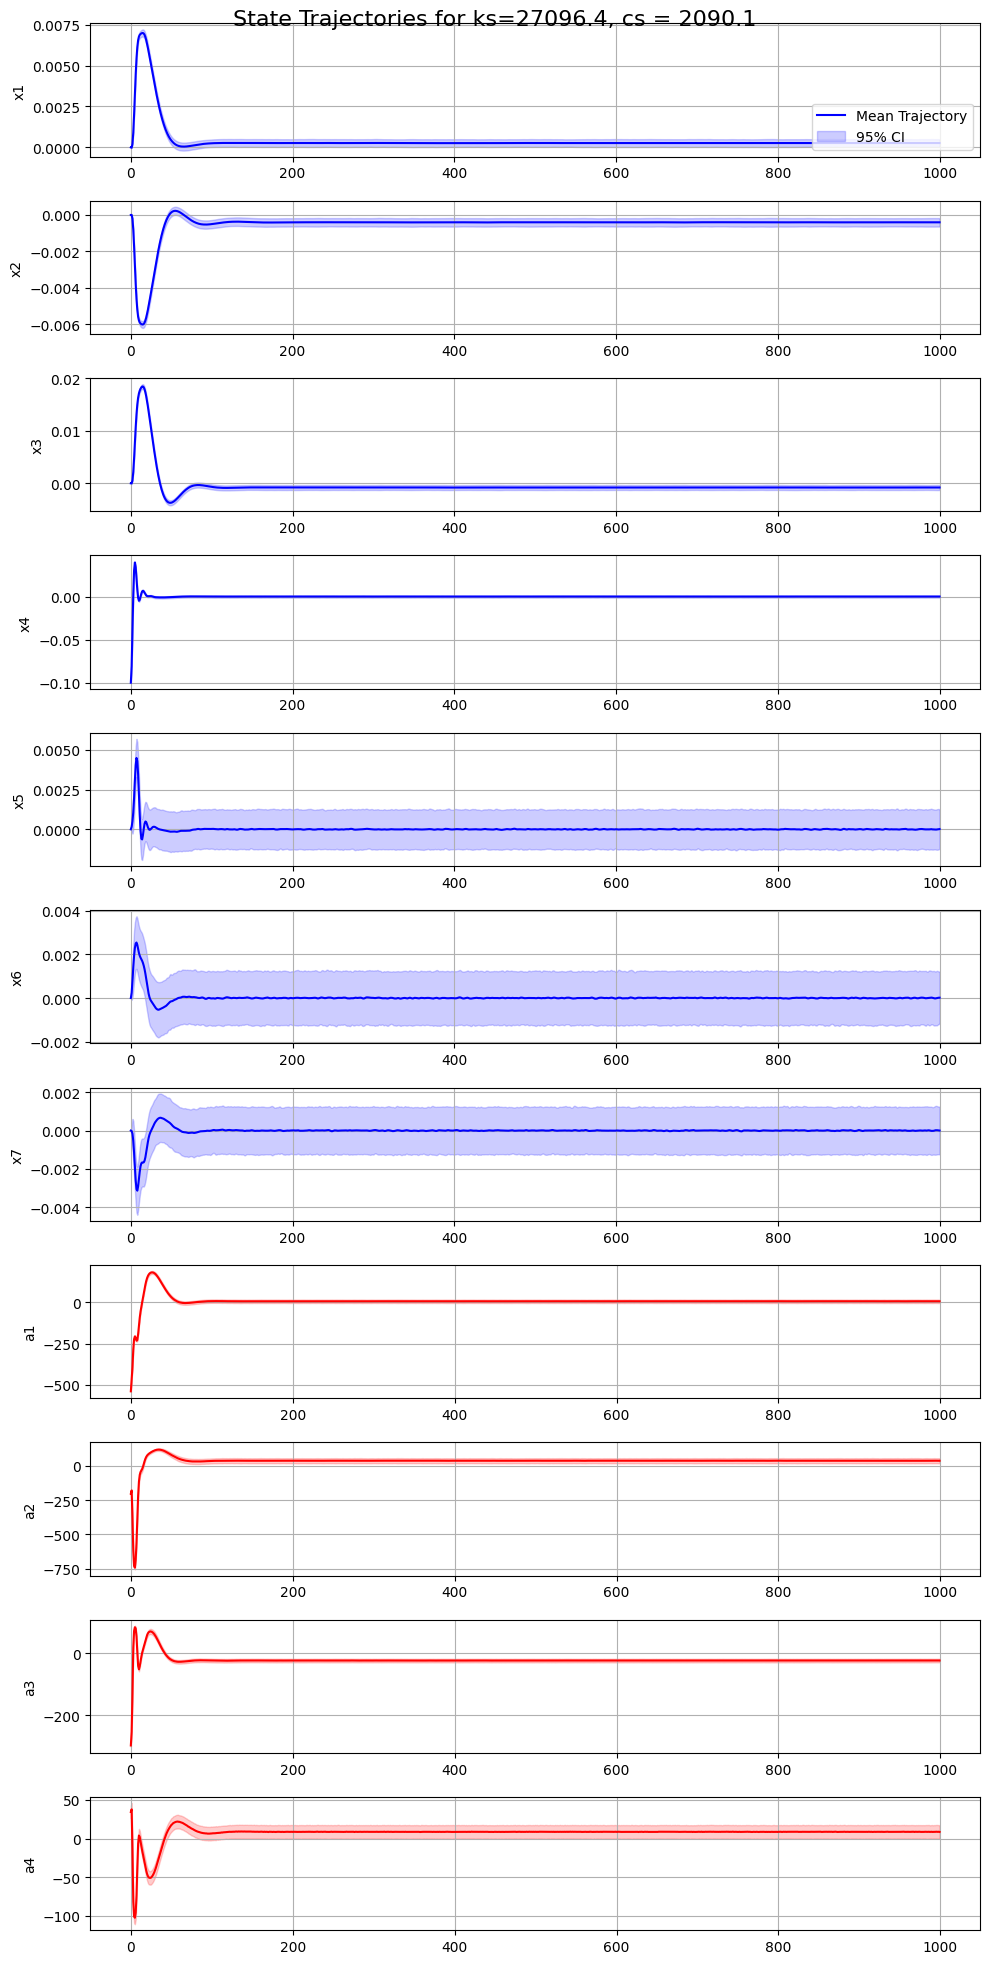

In [ ]:
from scipy.stats import sem, t

avg_score = np.average(score_total)
std_score = np.std(score_total)
print("Average Score: {:.3f}".format(avg_score))
print("Std of Score: {:.3f}".format(std_score))

# Calculate the t critical value for 95% confidence interval
confidence = 0.95
n = x_sys.shape[0]  # number of trajectories
t_critical = t.ppf((1 + confidence) / 2., n - 1)


mean_trajs = []
for i in range(x_sys.shape[2]):
    mean_trajs.append(np.mean(x_sys[:, :, i], axis=0))

mean_trajs_a = []
for i in range(a_sys.shape[2]):
    mean_trajs_a.append(np.mean(a_sys[:, :, i], axis=0))

std_trajs = []; margin_of_error = []; lower_trajs = []; upper_trajs = []
for i in range(x_sys.shape[2]):
    std_trajs.append(np.std(x_sys[:, :, i], axis=0))
    margin_of_error.append(t_critical * std_trajs[i])
    lower_trajs.append(mean_trajs[i] - margin_of_error[i])
    upper_trajs.append(mean_trajs[i] + margin_of_error[i])

std_trajs_a = []; margin_of_error_a = []; lower_trajs_a = []; upper_trajs_a = []
for i in range(a_sys.shape[2]):
    std_trajs_a.append(np.std(a_sys[:, :, i], axis=0))
    margin_of_error_a.append(t_critical * std_trajs_a[i])
    lower_trajs_a.append(mean_trajs_a[i] - margin_of_error_a[i])
    upper_trajs_a.append(mean_trajs_a[i] + margin_of_error_a[i])


t_vec = np.arange(0, 1001)

# Create the mean trajectories with 95% confidence interval
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11) = plt.subplots(11, 1, figsize=(10, 20))

ax1.plot(t_vec, mean_trajs[0], color='b', label='Mean Trajectory')
ax1.fill_between(t_vec, lower_trajs[0], upper_trajs[0], color='b', alpha=0.2, label="95% CI")
ax1.set_ylabel('x1')
# ax1.set_ylim((-3.75,1.0))
ax1.legend(loc='lower right')
ax1.grid(True)
ax1.legend(loc='lower right')


ax2.plot(t_vec, mean_trajs[1], color='b')
ax2.fill_between(t_vec, lower_trajs[1], upper_trajs[1], color='b', alpha=0.2)
ax2.set_ylabel('x2')
# ax2.set_ylim((-4,2))
ax2.grid(True)

ax3.plot(t_vec, mean_trajs[2], color='b')
ax3.fill_between(t_vec, lower_trajs[2], upper_trajs[2], color='b', alpha=0.2)
ax3.set_ylabel('x3')
# ax3.set_ylim((-4,2))
ax3.grid(True)

ax4.plot(t_vec, mean_trajs[3], color='b')
ax4.fill_between(t_vec, lower_trajs[3], upper_trajs[3], color='b', alpha=0.2)
ax4.set_ylabel('x4')
# ax4.set_ylim((-0.6,1.55))
ax4.grid(True)

ax5.plot(t_vec, mean_trajs[4], color='b')
ax5.fill_between(t_vec, lower_trajs[4], upper_trajs[4], color='b', alpha=0.2)
ax5.set_ylabel('x5')
# ax5.set_ylim((-0.6,1.55))
ax5.grid(True)

ax6.plot(t_vec, mean_trajs[5], color='b')
ax6.fill_between(t_vec, lower_trajs[5], upper_trajs[5], color='b', alpha=0.2)
ax6.set_ylabel('x6')
# ax6.set_ylim((-0.6,1.55))
ax6.grid(True)

ax7.plot(t_vec, mean_trajs[6], color='b')
ax7.fill_between(t_vec, lower_trajs[6], upper_trajs[6], color='b', alpha=0.2)
ax7.set_ylabel('x7')
# ax7.set_ylim((-0.6,1.55))
ax7.grid(True)

ax8.plot(t_vec[:-1], mean_trajs_a[0], color='r')
ax8.fill_between(t_vec[:-1], lower_trajs_a[0], upper_trajs_a[0], color='r', alpha=0.2)
ax8.set_ylabel('a1')
# ax8.set_ylim((-0.6,1.55))
ax8.grid(True)

ax9.plot(t_vec[:-1], mean_trajs_a[1], color='r')
ax9.fill_between(t_vec[:-1], lower_trajs_a[1], upper_trajs_a[1], color='r', alpha=0.2)
ax9.set_ylabel('a2')
# ax9.set_ylim((-0.6,1.55))
ax9.grid(True)

ax10.plot(t_vec[:-1], mean_trajs_a[2], color='r')
ax10.fill_between(t_vec[:-1], lower_trajs_a[2], upper_trajs_a[2], color='r', alpha=0.2)
ax10.set_ylabel('a3')
# ax10.set_ylim((-0.6,1.55))
ax10.grid(True)

ax11.plot(t_vec[:-1], mean_trajs_a[3], color='r')
ax11.fill_between(t_vec[:-1], lower_trajs_a[3], upper_trajs_a[3], color='r', alpha=0.2)
ax11.set_ylabel('a4')
# ax11.set_ylim((-0.6,1.55))
ax11.grid(True)


plt.suptitle('State Trajectories for ks='+'{0:.1f}'.format(ks)+', cs = '+'{0:.1f}'.format(cs), fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Save main state trajectories (x1 to x7) and their confidence intervals
traj_data = {
    't': t_vec
}
for i in range(7):
    traj_data[f'mean_x{i+1}'] = mean_trajs[i]
    traj_data[f'lower_x{i+1}'] = lower_trajs[i]
    traj_data[f'upper_x{i+1}'] = upper_trajs[i]

df_traj = pd.DataFrame(traj_data)
df_traj.to_csv('state_trajs_first_opt.csv', index=False)


# Save control trajectories (a1 to a4) and their confidence intervals
traj_a_data = {
    't': t_vec[:-1]  # actions usually one step shorter
}
for i in range(4):
    traj_a_data[f'mean_a{i+1}'] = mean_trajs_a[i]
    traj_a_data[f'lower_a{i+1}'] = lower_trajs_a[i]
    traj_a_data[f'upper_a{i+1}'] = upper_trajs_a[i]

df_traj_a = pd.DataFrame(traj_a_data)
df_traj_a.to_csv('control_trajs_first_opt.csv', index=False)


## Generation 1 (prescribed the dz/dt data)

In this stage, the system parameters $k_s$ and $c_s$ should be fixed, while only the control policy can be updated,

where the real system deviates from what we model by adding a nonlinear term, bias and uniform random variables for disturbances

The policy is retrained every 20 steps (rollout_len)

## Define the Real System
1. Nonlinearity of springs and dampers
2. Non-uniform Masses for mus 
3. Asymmetric parameters hcg + 0.05

In [ ]:
def vehicle_dynamics_real(t, x, params, u=None, ax=0, vx=0, steering_angle=0, z_r=None, z_r_dot=None):
    """
    Calculates the time derivative of the vehicle's state vector (with nonlinear terms for springs and dampers), following the same architecture of the original dynamic function.
    """

    # Unpack state variables
    zs, theta, phi, zu1, zu2, zu3, zu4, \
        zs_dot, theta_dot, phi_dot, zu1_dot, zu2_dot, zu3_dot, zu4_dot = x

    # Unpack parameters
    ms = params['ms']
    I_theta = params['I_theta']
    I_phi = params['I_phi']
    mu = params['mu']  # A list/array of [mu1, mu2, mu3, mu4]
    ks = params['ks']
    cs = params['cs']
    kt = params['kt']
    ct = params['ct']
    lf = params['lf']
    lr = params['lr']
    tf = params['tf']
    tr = params['tr']
    h_cg = params['h_cg']

    # Default control inputs and road inputs if not provided
    if u is None:
        u = np.zeros(4)
    if z_r is None:
        z_r = np.zeros(4)
    if z_r_dot is None:
        z_r_dot = np.zeros(4)

    # State derivatives - first part are simply the current velocities
    x_dot = np.zeros(14)
    x_dot[0] = zs_dot
    x_dot[1] = theta_dot
    x_dot[2] = phi_dot
    x_dot[3] = zu1_dot
    x_dot[4] = zu2_dot
    x_dot[5] = zu3_dot
    x_dot[6] = zu4_dot

    # Calculate Delta_i and Delta_dot_i
    Delta = np.array([
        -lf * theta + tf * phi,
        -lf * theta - tf * phi,
        lr * theta + tr * phi,
        lr * theta - tr * phi
    ])

    Delta_dot = np.array([
        -lf * theta_dot + tf * phi_dot,
        -lf * theta_dot - tf * phi_dot,
        lr * theta_dot + tr * phi_dot,
        lr * theta_dot - tr * phi_dot
    ])

    # Combine unsprung mass vertical positions and velocities for easier indexing
    zu = np.array([zu1, zu2, zu3, zu4])
    zu_dot = np.array([zu1_dot, zu2_dot, zu3_dot, zu4_dot])

    knl = 0.1*ks; cnl = cs*0.1
    # Calculate F_Si (Suspension forces)
    F_Si = np.zeros(4)
    for i in range(4):
        F_Si[i] = ks * (zu[i] - zs - Delta[i]) + cs * (zu_dot[i] - zs_dot - Delta_dot[i]) \
            + knl * (zu[i] - zs - Delta[i])**3 + cnl * abs(zu_dot[i] - zs_dot - Delta_dot[i]) * (zu_dot[i] - zs_dot - Delta_dot[i])

    # Calculate F_Ti (Tire forces)
    F_Ti = np.zeros(4)
    for i in range(4):
        F_Ti[i] = kt[i] * (z_r[i] - zu[i]) + ct * (z_r_dot[i] - zu_dot[i])    

    # Calculate accelerations (the second part of x_dot)

    # Sprung Mass Vertical Motion (ddot_zs)
    sum_F_S_plus_u = np.sum(F_Si + u)
    x_dot[7] = sum_F_S_plus_u / ms  # ddot_zs

    # Pitch Motion (ddot_theta)
    x_i = np.array([-lf, -lf, lr, lr])
    sum_pitch_terms = np.sum((F_Si + u) * x_i) + ms * h_cg * ax
    x_dot[8] = sum_pitch_terms / I_theta  # ddot_theta

    # Roll Motion (ddot_phi)
    y_i = np.array([tf, -tf, tr, -tr])
    ay= vx**2*np.tan(steering_angle)/(lf+lr)
    sum_roll_terms = np.sum((F_Si + u) * y_i) + ms * h_cg * ay
    x_dot[9] = sum_roll_terms / I_phi  # ddot_phi

    # Unsprung Mass (Wheel) Motion (ddot_zui)
    for i in range(4):
        x_dot[10 + i] = (F_Ti[i] - F_Si[i] - u[i]) / mu[i]  # ddot_zu1, ddot_zu2, ddot_zu3, ddot_zu4

    return x_dot


def step_rk4_real(x, u, params, dt, ax=0, vx=0, steering_angle=0, z_r=None, z_r_dot=None):
    f = lambda x_: vehicle_dynamics_real(0, x_, params, u, ax, vx, steering_angle, z_r, z_r_dot)
    k1 = f(x)
    k2 = f(x + 0.5 * dt * k1)
    k3 = f(x + 0.5 * dt * k2)
    k4 = f(x + dt * k3)
    x_next = x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return x_next

In [ ]:
class DynamicSystemEnvReal(gym.Env):
    def __init__(self):
        # parameters
        self.params = {
            'ms': 1500.0*1.1,       # Sprung mass (kg)
            'I_theta': 2500.0*1.1,  # Pitch moment of inertia (kg*m^2)
            'I_phi': 500.0*1.1,     # Roll moment of inertia (kg*m^2)
            'mu': [50.0+10.0, 50.0, 50.0-5.0, 50.0], # Unsprung masses for each wheel (kg)
            'ks': 25000.0,      # Suspension stiffness (N/m)
            'cs': 2000.0,       # Suspension damping (N*s/m)
            'kt': [200000.0*0.9,200000.0*1.2,200000.0*1.1,200000.0*0.9],     # Tire stiffness (N/m)
            'ct': 150.0,        # Tire damping (N*s/m)
            'lf': 1.35,         # Distance from CG to front axle (m)
            'lr': 1.35,         # Distance from CG to rear axle (m)
            'tf': 0.75,         # Half-track width of front axle (m)
            'tr': 0.75,         # Half-track width of rear axle (m)
            'h_cg': 0.55+0.05   # height of the CG above the ground (m) for a mid-size passenger vehicle
        }
        self.ks_max = 40000
        self.ks_min = 10000
        self.cs_max = 3000
        self.cs_min = 500

        self.dt = 0.01 # time step, unit: s

        # System dynamics parameters
        self.Q = np.array([[10,0,0,0], [0,1,0,0], [0,0,50,0], [0,0,0,5]])     # State cost matrix
        self.R = 0.000001                                 # Action cost
        
        # State and action spaces
        self.observation_space = spaces.Box(low=-5, high=5, shape=(14,), dtype=np.float32)
        self.action_space = spaces.Box(low=-3000, high=3000, shape=(1,), dtype=np.float32)
        
        # Initial state
        self.state = np.zeros(14)
        
        # Maximum episode steps
        self.max_steps = 1000
        self.current_step = 0

    def step(self, action, ks_normalized, cs_normalized, ax, vx, steering_angle, zr, zr_dot):

        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.params['ks'] = ks
        self.params['cs'] = cs

        # Clip action to stay within action bounds
        action = np.clip(action, self.action_space.low, self.action_space.high)
        
        # Update state based on system dynamics
        x = self.state

        x_next = step_rk4_real(x, action, self.params, self.dt, ax, vx, steering_angle, zr, zr_dot)

        # Assuming x = [z_s, theta, phi, z_u1, z_u2, z_u3, z_u4, ..., z_s_dot, theta_dot, ...]
        zs = x_next[0]
        pitch_angle = x_next[1]
        roll_angle = x_next[2]
        zu1 = x_next[3]
        zu2 = x_next[4]
        zu3 = x_next[5]
        zu4 = x_next[6]
        dzs = x_next[7]
        pitch_vel = x_next[8]
        roll_vel = x_next[9]
        dzu1 = x_next[10]
        dzu2 = x_next[11]
        dzu3 = x_next[12]
        dzu4 = x_next[13]
        
        az = (x_next[7]-x[7])/self.dt
        pitch_acc = (x_next[8]-x[8])/self.dt
        roll_acc = (x_next[9]-x[9])/self.dt

        # --- Comfort Index ---
        # Assume r_pitch = 1.0 m (longitude distance from CG)
        # Assume r_pitch = 0.5 m (latitude distance from CG)
        comfort_index = np.sqrt((10.0*az)**2 + (1.0*pitch_acc)**2 + (0.5*roll_acc)**2)

        # --- Handling Metrics ---
        pitch_penalty = pitch_angle**2           # squared pitch angle
        roll_penalty = roll_angle**2             # squared roll angle

        # Define reward as negative of weighted sum of penalties
        reward = -(
            comfort_index +
            pitch_penalty/0.00004 +
            roll_penalty/0.00003 +
            self.R * np.sum(action**2)/0.01
        )
        # reward = -comfort_index
        # reward = pitch_penalty/0.00004
        # reward = roll_penalty/0.00003
        # reward = self.R * np.sum(action**2)/0.01
                
        # Update state
        self.state = x_next
        
        # Check if done
        done = (self.current_step >= self.max_steps)
        self.current_step += 1
        
        return self.state, reward, done, {}
    
    def reset(self,ks_normalized,cs_normalized):
        # Reset state to initial value
        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.params['ks'] = ks
        self.params['cs'] = cs
        self.state = np.zeros(14)
        # self.state[3] = -0.1
        self.current_step = 0
        return self.state
    
    def render(self, mode='human'):
        pass

    def close(self):
        pass

In [ ]:
env_real = DynamicSystemEnvReal()

In [ ]:
# Read the CSV file into a DataFrame
df_mild = pd.read_csv('driving_wheel_data_mild.csv')
print(df_mild.head())

t_data = df_mild['time']
ax_data = df_mild['ax']
vx_data = df_mild['vx']
steering_data = df_mild['steering']
front_left_z = df_mild['front_left_z']
front_left_dz_dt = df_mild['front_left_dz_dt']
front_right_z = df_mild['front_right_z']
front_right_dz_dt = df_mild['front_right_dz_dt']
rear_left_z = df_mild['rear_left_z']
rear_left_dz_dt = df_mild['rear_left_dz_dt']
rear_right_z = df_mild['rear_right_z']
rear_right_dz_dt = df_mild['rear_right_dz_dt']

   time        ax    vx  steering  front_left_z  front_left_dz_dt  \
0  0.00  1.937074  0.00       0.0      0.003956          0.000000   
1  0.01  1.938014  0.01       0.0      0.003956         -0.000026   
2  0.02  1.938945  0.03       0.0      0.003956         -0.000079   
3  0.03  1.939869  0.05       0.0      0.003956         -0.000132   
4  0.04  1.940786  0.07       0.0      0.003956         -0.000185   

   front_right_z  front_right_dz_dt  rear_left_z  rear_left_dz_dt  \
0            0.0           0.000000     0.006526         0.000000   
1            0.0          -0.000050     0.006526        -0.000007   
2            0.0          -0.000151     0.006526        -0.000022   
3            0.0          -0.000252     0.006526        -0.000037   
4            0.0          -0.000352     0.006526        -0.000052   

   rear_right_z  rear_right_dz_dt  
0      0.006009          0.000000  
1      0.006009          0.000014  
2      0.006009          0.000043  
3      0.006009          0

In [ ]:
# Check if there are any NaN values
has_nan = df_mild.isnull().values.any()

print("Contains NaN values?" , has_nan)

print(df_mild.isnull().sum())


Contains NaN values? False
time                 0
ax                   0
vx                   0
steering             0
front_left_z         0
front_left_dz_dt     0
front_right_z        0
front_right_dz_dt    0
rear_left_z          0
rear_left_dz_dt      0
rear_right_z         0
rear_right_dz_dt     0
dtype: int64


In [ ]:
model_gen0 = copy.deepcopy(model) # save the model (for back up)
# model = copy.deepcopy(model_gen0) # load the model (load from the back up)


Use "env" for ideal environment (only used for comparing with the real system behavior)

In [ ]:
# import copy
ks_1 = copy.deepcopy(ks) # after the first CCD optimization
cs_1 = copy.deepcopy(cs) # after the first CCD optimization
ks_normalized = (ks-env_real.ks_min)/(env_real.ks_max-env_real.ks_min)
cs_normalized = (cs-env_real.cs_min)/(env_real.cs_max-env_real.cs_min)

print_interval = 10
rollout_len = 1
rollout = []
score_history = []
N_total = 120000
score = 0.0
print_interval = 10
temp_training_data = []
training_len = 10
s = env_real.reset(ks_normalized, cs_normalized)
done = False
count = 0
x_sys = np.zeros((N_total+1,14))
y_sys = np.zeros((N_total+1,11))
a_sys = np.zeros((N_total,4))

x_sys[0,:] = np.array([s[0],s[1],s[2],s[3],s[4],s[5],s[6],s[7],s[8],s[9],s[10],s[11],s[12],s[13]])
y = C@s
y_sys[0,:] = np.array([y[0],y[1],y[2],y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10]])

model.data = []
while count < N_total:
    for t in range(rollout_len):
        y = C@s
        y_tmp = np.append(cs,y)
        y_tmp = np.append(ks,y_tmp)
        y_normalized = (y - lower_bounds_y[2:]) / (upper_bounds_y[2:] - lower_bounds_y[2:]) # only observed states
        x = (y_tmp - lower_bounds_y) / (upper_bounds_y - lower_bounds_y) # all input (ks,cs,y1,...,y11)
        normalized_inputs_tmp = torch.tensor(x.reshape(1,13), dtype=torch.float32)
        # print(normalized_inputs_tmp)
        mu, std = model.pi(normalized_inputs_tmp)
        dist = Normal(mu, std)
        a = dist.sample()
        log_prob = dist.log_prob(a)
        action_tmp = a.cpu().detach().numpy().flatten()*3000
        action = np.clip(action_tmp, env_real.action_space.low, env_real.action_space.high)
        vx = vx_data[count]
        ax = ax_data[count]
        steering_angle = steering_data[count]
        # Generate noises for zr and zr_dot
        zr = np.array([front_left_z[count], front_right_z[count], rear_left_z[count], rear_right_z[count]])
        zr_dot = np.array([front_left_dz_dt[count], front_right_dz_dt[count], rear_left_dz_dt[count], rear_right_dz_dt[count]])
        s_prime, r, done, _ = env.step(action,ks_normalized,cs_normalized,ax,vx,steering_angle,zr,zr_dot)
        y_prime = C@s_prime
        y_prime_normalized = (y_prime - lower_bounds_y[2:]) / (upper_bounds_y[2:] - lower_bounds_y[2:])
        rollout.append((y, action/3000, r/1000.0, y_prime, log_prob.cpu().detach().numpy().flatten(), done))
        if len(rollout) == rollout_len*1000:
            model.put_data_policy_update_only(rollout)
            rollout = []
            model.train_net(ks,cs)
            print(f"Policy updated at step {count}")

        s = s_prime

        x_sys[count+1,:] = s_prime
        y_sys[count+1,:] = y_prime
        a_sys[count,:] = action
        score += r
        count += 1

    

    if count%print_interval==0:
        print("# of steps :{}, avg score : {:.4f}".format(count, score/print_interval))
        score = 0.0

env.close()

# model_first_gen = copy.deepcopy(model) # save the model


# of steps :10, avg score : -5.1663
# of steps :20, avg score : -2.6312
# of steps :30, avg score : -4.9190
# of steps :40, avg score : -6.4431
# of steps :50, avg score : -8.5616
# of steps :60, avg score : -6.5194
# of steps :70, avg score : -5.6833
# of steps :80, avg score : -4.8585
# of steps :90, avg score : -4.4705
# of steps :100, avg score : -5.0129
# of steps :110, avg score : -5.8942
# of steps :120, avg score : -6.6325
# of steps :130, avg score : -4.7122
# of steps :140, avg score : -5.1199
# of steps :150, avg score : -4.7210
# of steps :160, avg score : -3.9950
# of steps :170, avg score : -3.4036
# of steps :180, avg score : -4.7808
# of steps :190, avg score : -2.7682
# of steps :200, avg score : -3.2520
# of steps :210, avg score : -3.0610
# of steps :220, avg score : -3.3204
# of steps :230, avg score : -3.8396
# of steps :240, avg score : -3.0816
# of steps :250, avg score : -3.5676
# of steps :260, avg score : -4.3501
# of steps :270, avg score : -2.7232
# of steps

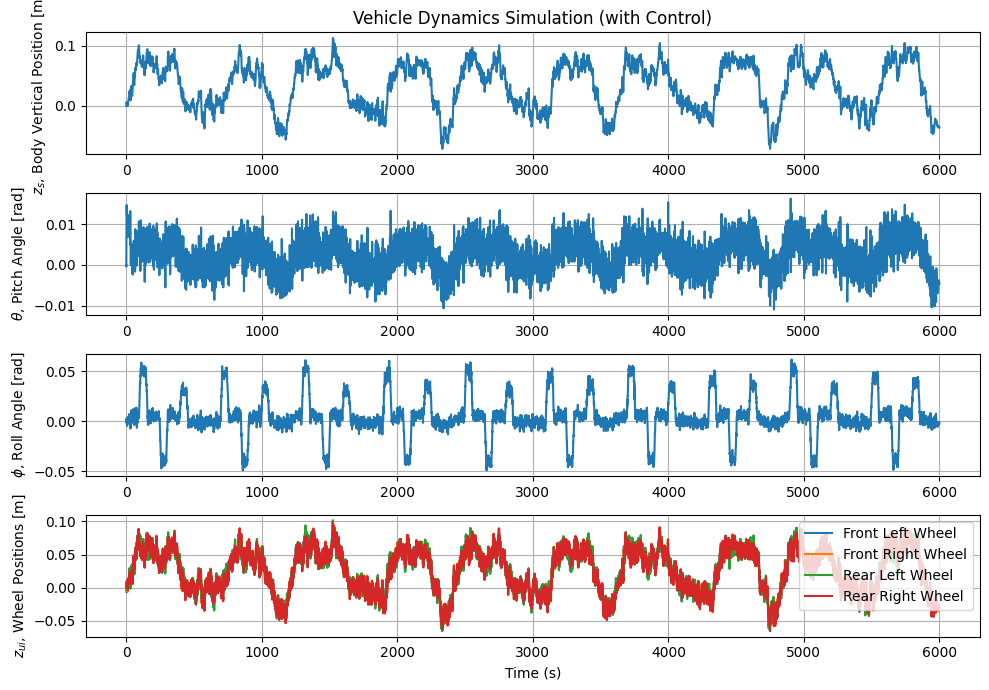

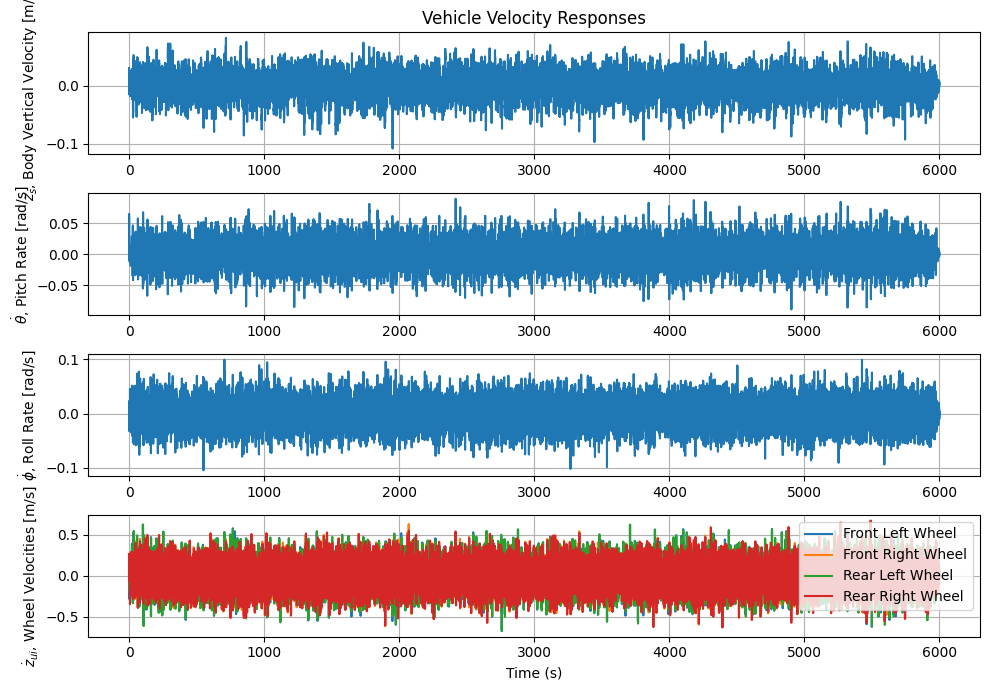

In [ ]:
import matplotlib.pyplot as plt

t = np.linspace(0,6000,N_total+1)

plt.figure(figsize=(10, 7))

# Plot Sprung Mass Vertical Position (zs)
plt.subplot(4, 1, 1)
plt.plot(t, x_sys[:, 0])
plt.ylabel(r"$z_s$, Body Vertical Position [m]")
plt.title('Vehicle Dynamics Simulation (with Control)')
plt.grid(True)

# Plot Pitch Angle (theta)
plt.subplot(4, 1, 2)
plt.plot(t, x_sys[:, 1])
plt.ylabel(r"$\theta$, Pitch Angle [rad]")
plt.grid(True)

# Plot Roll Angle (phi)
plt.subplot(4, 1, 3)
plt.plot(t, x_sys[:, 2])
plt.ylabel(r"$\phi$, Roll Angle [rad]")
plt.grid(True)

# Plot Unsprung Mass Vertical Positions (zu1, zu2, zu3, zu4)
plt.subplot(4, 1, 4)
plt.plot(t, x_sys[:, 3], label='Front Left Wheel')
plt.plot(t, x_sys[:, 4], label='Front Right Wheel')
plt.plot(t, x_sys[:, 5], label='Rear Left Wheel')
plt.plot(t, x_sys[:, 6], label='Rear Right Wheel')
plt.ylabel(r"$z_{ui}$, Wheel Positions [m]")
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))

# Plot Sprung Mass Vertical Velocity (dzs/dt)
plt.subplot(4, 1, 1)
plt.plot(t, x_sys[:, 7])
plt.ylabel(r"$\dot{z}_s$, Body Vertical Velocity [m/s]")
plt.title('Vehicle Velocity Responses')
plt.grid(True)

# Plot Pitch Rate (dtheta/dt)
plt.subplot(4, 1, 2)
plt.plot(t, x_sys[:, 8])
plt.ylabel(r"$\dot{\theta}$, Pitch Rate [rad/s]")
plt.grid(True)

# Plot Roll Rate (dphi/dt)
plt.subplot(4, 1, 3)
plt.plot(t, x_sys[:, 9])
plt.ylabel(r"$\dot{\phi}$, Roll Rate [rad/s]")
plt.grid(True)

# Plot Unsprung Mass Vertical Velocities (dzu1/dt to dzu4/dt)
plt.subplot(4, 1, 4)
plt.plot(t, x_sys[:, 10], label='Front Left Wheel')
plt.plot(t, x_sys[:, 11], label='Front Right Wheel')
plt.plot(t, x_sys[:, 12], label='Rear Left Wheel')
plt.plot(t, x_sys[:, 13], label='Rear Right Wheel')
plt.ylabel(r"$\dot{z}_{ui}$, Wheel Velocities [m/s]")
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Use "env_real" for real environment

In [ ]:
model = copy.deepcopy(model_gen0) # load the model (load from the back up)

ks_1 = copy.deepcopy(ks) # after the first CCD optimization
cs_1 = copy.deepcopy(cs) # after the first CCD optimization
ks_normalized = (ks-env_real.ks_min)/(env_real.ks_max-env_real.ks_min)
cs_normalized = (cs-env_real.cs_min)/(env_real.cs_max-env_real.cs_min)

print_interval = 10
rollout_len = 1
rollout = []
score_history = []
N_total = 120000
score = 0.0
print_interval = 10
temp_training_data = []
training_len = 10
s = env_real.reset(ks_normalized, cs_normalized)
done = False
count = 0
x_sys = np.zeros((N_total+1,14))
y_sys = np.zeros((N_total+1,11))
a_sys = np.zeros((N_total,4))

x_sys[0,:] = np.array([s[0],s[1],s[2],s[3],s[4],s[5],s[6],s[7],s[8],s[9],s[10],s[11],s[12],s[13]])
y = C@s
y_sys[0,:] = np.array([y[0],y[1],y[2],y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10]])

model.data = []
while count < N_total:
    y = C@s
    y_tmp = np.append(cs,y)
    y_tmp = np.append(ks,y_tmp)
    y_normalized = (y - lower_bounds_y[2:]) / (upper_bounds_y[2:] - lower_bounds_y[2:]) # only observed states
    x = (y_tmp - lower_bounds_y) / (upper_bounds_y - lower_bounds_y) # all input (ks,cs,y1,...,y11)
    normalized_inputs_tmp = torch.tensor(x.reshape(1,13), dtype=torch.float32)
    # print(normalized_inputs_tmp)
    mu, std = model.pi(normalized_inputs_tmp)
    dist = Normal(mu, std)
    a = dist.sample()
    log_prob = dist.log_prob(a)
    action_tmp = a.cpu().detach().numpy().flatten()*3000
    action = np.clip(action_tmp, env_real.action_space.low, env_real.action_space.high)
    vx = vx_data[count]
    ax = ax_data[count]
    steering_angle = steering_data[count]
    # Generate noises for zr and zr_dot
    zr = np.array([front_left_z[count], front_right_z[count], rear_left_z[count], rear_right_z[count]])
    zr_dot = np.array([front_left_dz_dt[count], front_right_dz_dt[count], rear_left_dz_dt[count], rear_right_dz_dt[count]])
    s_prime, r, done, _ = env_real.step(action,ks_normalized,cs_normalized,ax,vx,steering_angle,zr,zr_dot)
    y_prime = C@s_prime
    y_prime_normalized = (y_prime - lower_bounds_y[2:]) / (upper_bounds_y[2:] - lower_bounds_y[2:])
    rollout.append((y, action/3000, r/1000.0, y_prime, log_prob.cpu().detach().numpy().flatten(), done))
    if len(rollout) == rollout_len*1000:
        model.put_data_policy_update_only(rollout)
        rollout = []
        model.train_net(ks,cs)
        print(f"Policy updated at step {count}")

    s = s_prime

    x_sys[count+1,:] = s_prime
    y_sys[count+1,:] = y_prime
    a_sys[count,:] = action
    score += r
    count += 1

    if count%print_interval==0:
        print("# of steps :{}, avg score : {:.4f}".format(count, score/print_interval))
        score = 0.0

env_real.close()

model_first_gen = copy.deepcopy(model) # save the model

# of steps :10, avg score : -4.4904
# of steps :20, avg score : -3.0601
# of steps :30, avg score : -6.0309
# of steps :40, avg score : -8.1263
# of steps :50, avg score : -10.4607
# of steps :60, avg score : -8.5485
# of steps :70, avg score : -7.4805
# of steps :80, avg score : -6.3897
# of steps :90, avg score : -5.7727
# of steps :100, avg score : -6.3059
# of steps :110, avg score : -7.0610
# of steps :120, avg score : -7.9337
# of steps :130, avg score : -6.0651
# of steps :140, avg score : -6.3204
# of steps :150, avg score : -5.8129
# of steps :160, avg score : -4.9250
# of steps :170, avg score : -4.4133
# of steps :180, avg score : -5.4442
# of steps :190, avg score : -3.7100
# of steps :200, avg score : -4.0905
# of steps :210, avg score : -3.7534
# of steps :220, avg score : -4.0817
# of steps :230, avg score : -4.7309
# of steps :240, avg score : -4.1426
# of steps :250, avg score : -4.6282
# of steps :260, avg score : -5.0827
# of steps :270, avg score : -3.3571
# of step

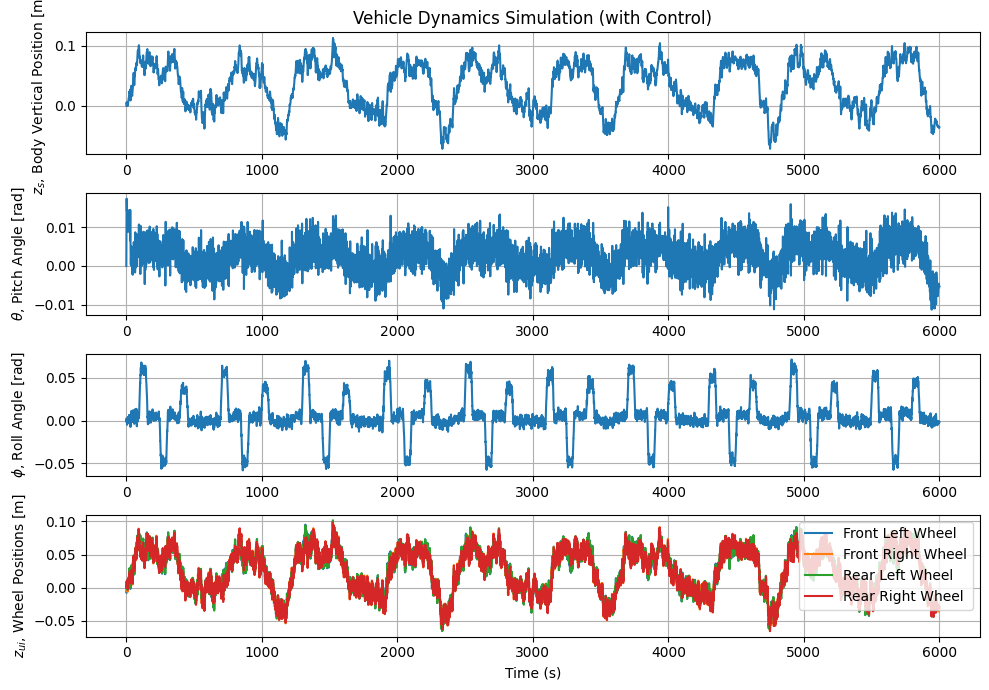

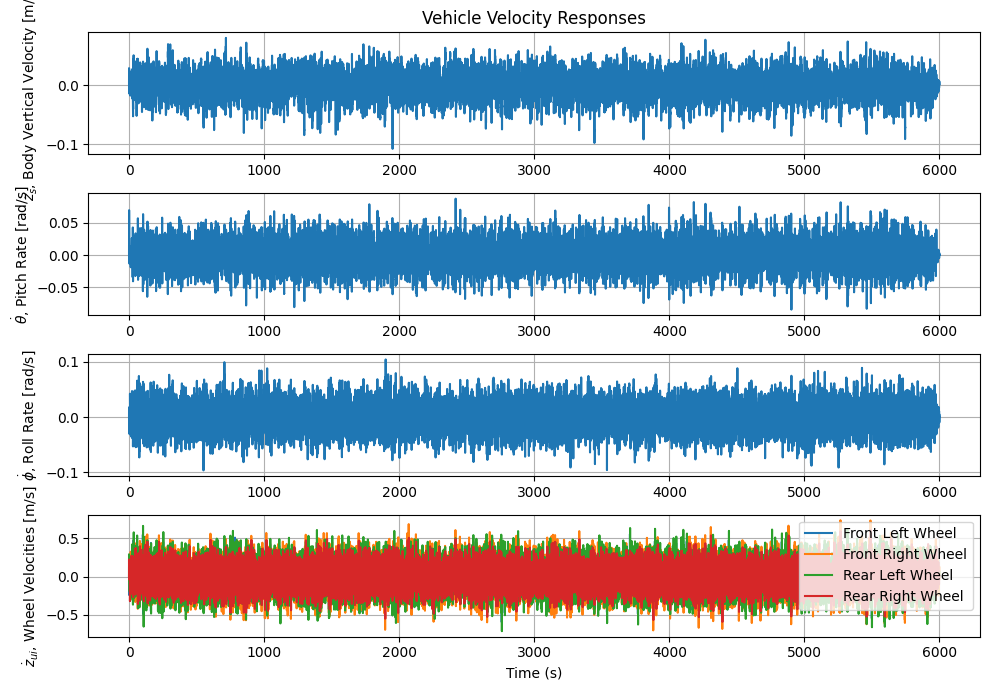

In [ ]:
import matplotlib.pyplot as plt

t = np.linspace(0,6000,N_total+1)

plt.figure(figsize=(10, 7))

# Plot Sprung Mass Vertical Position (zs)
plt.subplot(4, 1, 1)
plt.plot(t, x_sys[:, 0])
plt.ylabel(r"$z_s$, Body Vertical Position [m]")
plt.title('Vehicle Dynamics Simulation (with Control)')
plt.grid(True)

# Plot Pitch Angle (theta)
plt.subplot(4, 1, 2)
plt.plot(t, x_sys[:, 1])
plt.ylabel(r"$\theta$, Pitch Angle [rad]")
plt.grid(True)

# Plot Roll Angle (phi)
plt.subplot(4, 1, 3)
plt.plot(t, x_sys[:, 2])
plt.ylabel(r"$\phi$, Roll Angle [rad]")
plt.grid(True)

# Plot Unsprung Mass Vertical Positions (zu1, zu2, zu3, zu4)
plt.subplot(4, 1, 4)
plt.plot(t, x_sys[:, 3], label='Front Left Wheel')
plt.plot(t, x_sys[:, 4], label='Front Right Wheel')
plt.plot(t, x_sys[:, 5], label='Rear Left Wheel')
plt.plot(t, x_sys[:, 6], label='Rear Right Wheel')
plt.ylabel(r"$z_{ui}$, Wheel Positions [m]")
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))

# Plot Sprung Mass Vertical Velocity (dzs/dt)
plt.subplot(4, 1, 1)
plt.plot(t, x_sys[:, 7])
plt.ylabel(r"$\dot{z}_s$, Body Vertical Velocity [m/s]")
plt.title('Vehicle Velocity Responses')
plt.grid(True)

# Plot Pitch Rate (dtheta/dt)
plt.subplot(4, 1, 2)
plt.plot(t, x_sys[:, 8])
plt.ylabel(r"$\dot{\theta}$, Pitch Rate [rad/s]")
plt.grid(True)

# Plot Roll Rate (dphi/dt)
plt.subplot(4, 1, 3)
plt.plot(t, x_sys[:, 9])
plt.ylabel(r"$\dot{\phi}$, Roll Rate [rad/s]")
plt.grid(True)

# Plot Unsprung Mass Vertical Velocities (dzu1/dt to dzu4/dt)
plt.subplot(4, 1, 4)
plt.plot(t, x_sys[:, 10], label='Front Left Wheel')
plt.plot(t, x_sys[:, 11], label='Front Right Wheel')
plt.plot(t, x_sys[:, 12], label='Rear Left Wheel')
plt.plot(t, x_sys[:, 13], label='Rear Right Wheel')
plt.ylabel(r"$\dot{z}_{ui}$, Wheel Velocities [m/s]")
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Train a discrepany function for updated model

In [ ]:
y_input = y_sys[:-1, :]           # shape: (N-1, 11)
u_input = a_sys                   # shape: (N-1, 4)

y_nom = np.zeros_like(y_sys)
y_nom[0, :] = y_sys[0, :]

for i in range(len(u_input)):
    vx = vx_data[i]
    ax = ax_data[i]
    steering_angle = steering_data[i]
    s_prime, _, _, _ = env.step(a_sys[i, :],ks_normalized,cs_normalized,ax,vx,steering_angle,np.zeros(4),np.zeros(4))
    y_nom[i+1, :] = C@s_prime


e_input = y_sys[:-1, :] - y_nom[:-1, :]  # shape: (N-1, 11)
Input = np.hstack((y_input, e_input, u_input,ax_data.iloc[:len(u_input)].values.reshape(-1, 1),vx_data.iloc[:len(u_input)].values.reshape(-1, 1),steering_data.iloc[:len(u_input)].values.reshape(-1, 1)))  # shape: (N-1, 26)
Output = y_sys[1:,:]-y_nom[1:,:]


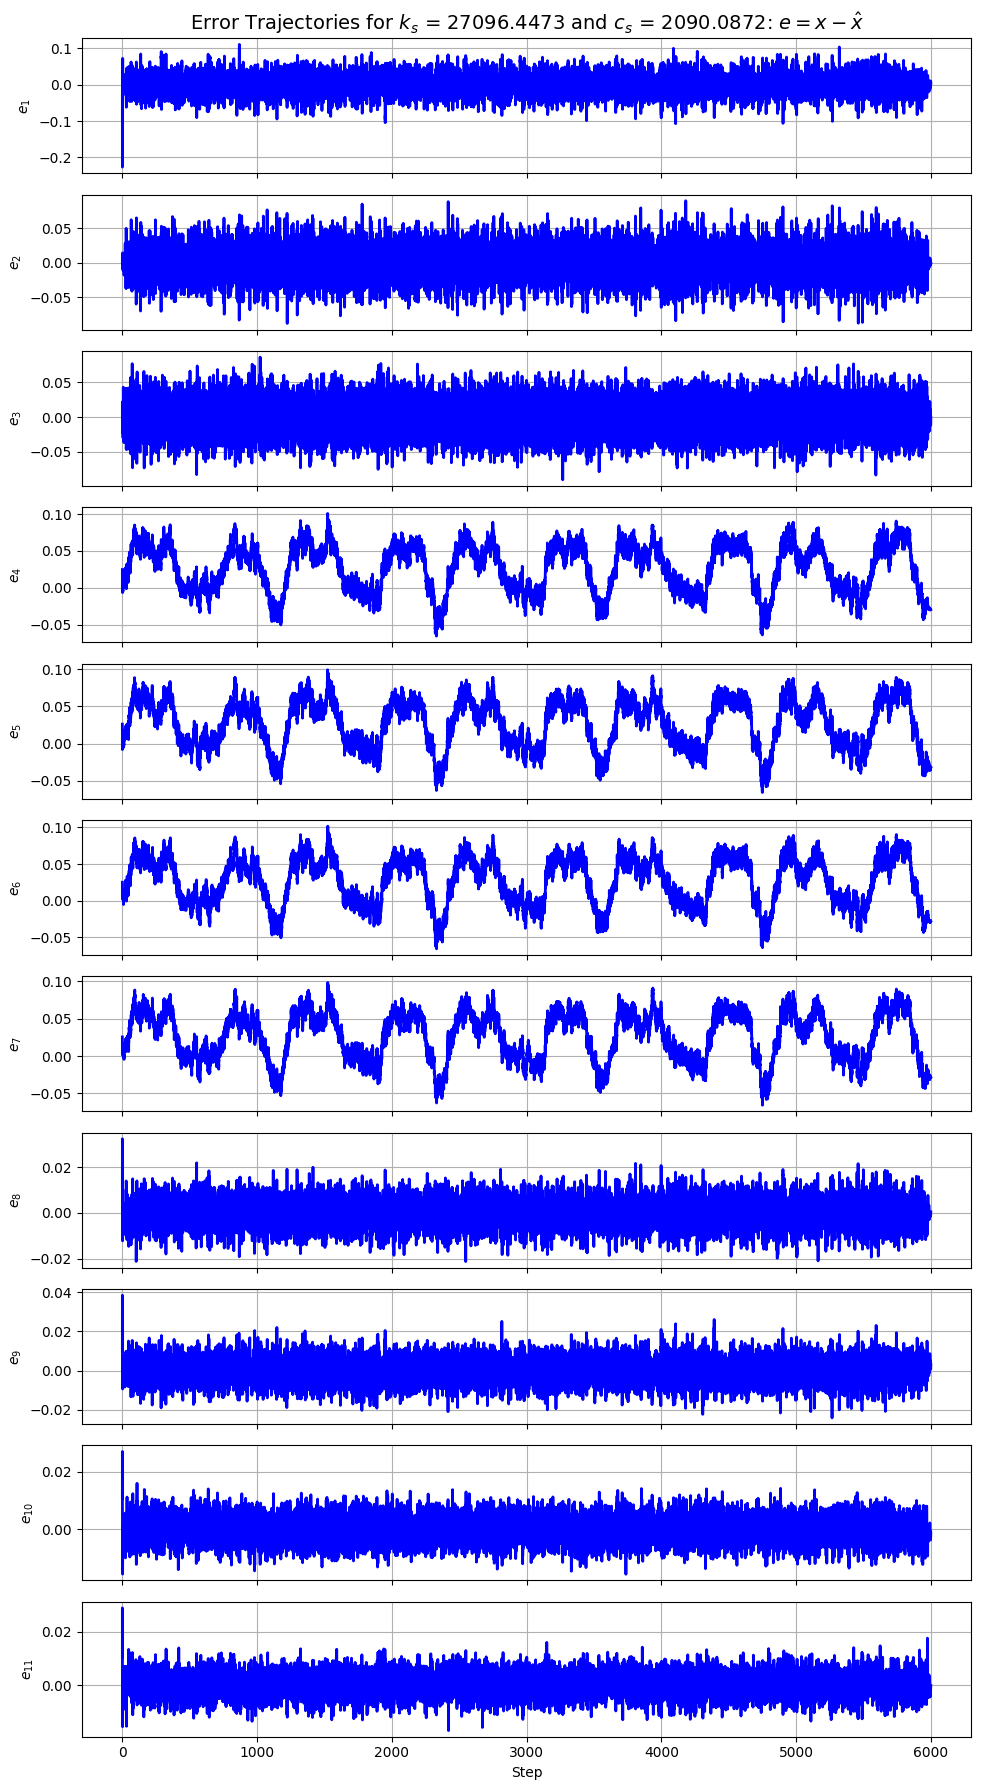

In [ ]:
fig, axes = plt.subplots(11, 1, figsize=(10, 18), sharex=True)

labels = [f'$e_{{{i+1}}}$' for i in range(11)]

for i in range(11):
    axes[i].plot(t[1:], Output[:, i], label=labels[i], color='b', linestyle='-', linewidth=2)
    axes[i].set_ylabel(labels[i])
    axes[i].grid(True)
    if i == 0:
        axes[i].set_title(f'Error Trajectories for $k_s$ = {ks:.4f} and $c_s$ = {cs:.4f}: $e = x - \hat{{x}}$', fontsize=14)
    if i == 10:
        axes[i].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SurrogateDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles

    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - preds[:, i::len(self.quantiles)]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss

class SurrogateModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, quantiles):
        super().__init__()
        self.quantiles = quantiles
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))
            prev_dim = hidden_dim
        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, output_dim * len(quantiles))

    def forward(self, x):
        x = self.hidden_layers(x)
        return self.output_layer(x)



In [ ]:
from sklearn.model_selection import train_test_split

batch_size = 32
X_train, X_val, y_train, y_val = train_test_split(Input, Output, test_size=0.2, random_state=42)

# Create dataset and dataloader
dataset = SurrogateDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

val_dataset = SurrogateDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
# Hyperparameters
input_dim =  29
output_dim = 11
hidden_dims = [64, 128, 128, 64]
quantiles = [0.1, 0.5, 0.9]
learning_rate = 0.001
batch_size = 128
num_epochs = 100

# Initialize model, loss, and optimizer
model_dysys = SurrogateModel(input_dim, output_dim, hidden_dims, quantiles)
criterion = QuantileLoss(quantiles)
optimizer = optim.Adam(model_dysys.parameters(), lr=learning_rate)

val_losses = []
# Training loop with loss tracking
epoch_losses = []
for epoch in range(num_epochs):
    model_dysys.train()
    total_loss = 0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model_dysys(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation
    model_dysys.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model_dysys(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    avg_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")



Epoch [1/100], Loss: 0.0200, Val Loss: 0.0147
Epoch [2/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [3/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [4/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [5/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [6/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [7/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [8/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [9/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [10/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [11/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [12/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [13/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [14/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [15/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [16/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [17/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [18/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [19/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [20/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [21/100], Loss: 0.0147, Val Loss: 0.0147
Epoch [22/100], Loss: 

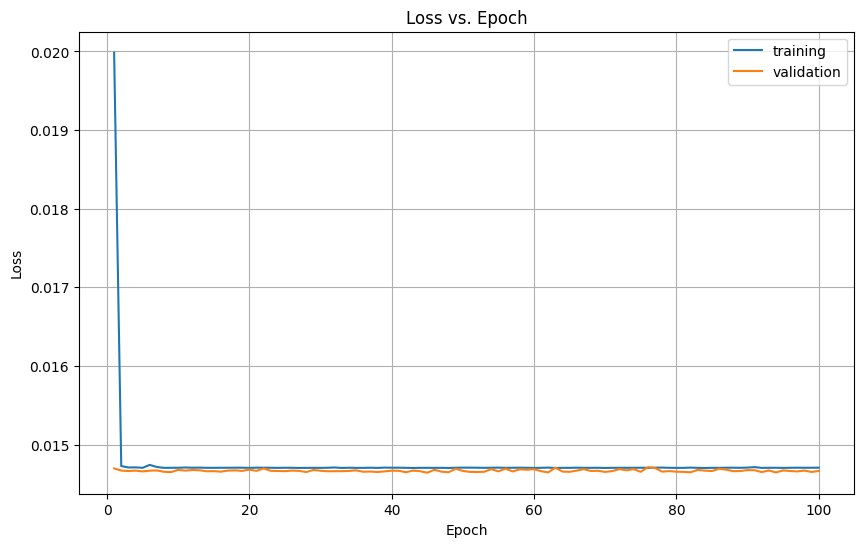

Prediction:
Output 1: [-0.031087785959243774, -0.0005745860980823636, 0.032902851700782776]
Output 2: [-0.0293987188488245, 0.0012694537872448564, 0.0303083136677742]
Output 3: [-0.02148391120135784, 0.003026715712621808, 0.02663329243659973]
Output 4: [-0.0178415235131979, 0.03211525082588196, 0.06530845165252686]
Output 5: [-0.016714513301849365, 0.03261595591902733, 0.06490255147218704]
Output 6: [-0.0184320081025362, 0.0324796661734581, 0.06470116227865219]
Output 7: [-0.016846856102347374, 0.03256285563111305, 0.06491116434335709]
Output 8: [-0.00650752242654562, -6.918003055034205e-05, 0.006382306572049856]
Output 9: [-0.005667366087436676, 0.0004862456116825342, 0.007426011376082897]
Output 10: [-0.0044397772289812565, -0.0008432673057541251, 0.004215974826365709]
Output 11: [-0.0038853685837239027, 0.001146142603829503, 0.0057064201682806015]


In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss vs epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='training')
plt.plot(range(1, num_epochs + 1), val_losses, label='validation')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Example prediction (as before)
model_dysys.eval()
with torch.no_grad():
    prediction = model_dysys(torch.tensor(X_val[0,:], dtype=torch.float32))
    prediction = prediction.reshape(output_dim, len(quantiles))
    print("Prediction:")
    for i in range(output_dim):
        print(f"Output {i+1}: {prediction[i].tolist()}")

In [ ]:
import pickle

variables_to_save = {
    'model_dysys': model_dysys
    # Add more variables as needed
}


with open('RL_PPO_CCD_susp_discrep_func2.pkl', 'wb') as file:
    pickle.dump(variables_to_save, file)

In [ ]:
# import pickle

# with open('RL_PPO_CCD_susp_discrep_func.pkl', 'rb') as file:
#     loaded_variables = pickle.load(file)
# model_dysys = loaded_variables['model_dysys']

In [ ]:
print_interval = 10
N_total = 120000
score = 0.0
training_len = 10
env.reset_origin(ks_normalized, cs_normalized)
s = env_real.reset(ks_normalized, cs_normalized)
done = False
count = 0
x_sys = np.zeros((N_total+1,14))
y_sys_pred_LB = np.zeros((N_total+1,11))
y_sys_pred = np.zeros((N_total+1,11))
y_sys_pred_UB = np.zeros((N_total+1,11))
a_sys = np.zeros((N_total,4))

x_sys[0,:] = np.array([s[0],s[1],s[2],s[3],s[4],s[5],s[6],s[7],s[8],s[9],s[10],s[11],s[12],s[13]])
y = C@s
y_nom = y
y_sys_pred_LB[0,:] = np.array([y[0],y[1],y[2],y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10]])
y_sys_pred[0,:] = np.array([y[0],y[1],y[2],y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10]])
y_sys_pred_UB[0,:] = np.array([y[0],y[1],y[2],y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10]])
e = np.zeros(11)
model.data = []
while count < N_total:
    y = C@s
    y_tmp = np.append(cs,y)
    y_tmp = np.append(ks,y_tmp)
    y_normalized = (y - lower_bounds_y[2:]) / (upper_bounds_y[2:] - lower_bounds_y[2:]) # only observed states
    x = (y_tmp - lower_bounds_y) / (upper_bounds_y - lower_bounds_y) # all input (ks,cs,y1,...,y11)
    normalized_inputs_tmp = torch.tensor(x.reshape(1,13), dtype=torch.float32)
    # print(normalized_inputs_tmp)
    mu, std = model.pi(normalized_inputs_tmp)
    dist = Normal(mu, std)
    a = dist.sample()
    log_prob = dist.log_prob(a)
    action_tmp = a.cpu().detach().numpy().flatten()*3000
    action = np.clip(action_tmp, env_real.action_space.low, env_real.action_space.high)
    vx = vx_data[count]
    ax = ax_data[count]
    steering_angle = steering_data[count]
    input_pred_model = np.concatenate((y, e, action, np.array([ax]), np.array([vx]), np.array([steering_angle])))
    e_prime_pred = model_dysys(torch.tensor(input_pred_model, dtype=torch.float32))
    e_prime_pred_numpy = e_prime_pred.detach().numpy()

    y_sys_pred_LB[count+1,:] = y_nom + np.array([e_prime_pred_numpy[0],e_prime_pred_numpy[3],e_prime_pred_numpy[6],\
                                                  e_prime_pred_numpy[9],e_prime_pred_numpy[12],e_prime_pred_numpy[15],\
                                                    e_prime_pred_numpy[18],e_prime_pred_numpy[21],e_prime_pred_numpy[24],\
                                                        e_prime_pred_numpy[27],e_prime_pred_numpy[30]])
    y_sys_pred[count+1,:] = y_nom + np.array([e_prime_pred_numpy[1],e_prime_pred_numpy[4],e_prime_pred_numpy[7],\
                                               e_prime_pred_numpy[10],e_prime_pred_numpy[13],e_prime_pred_numpy[16],\
                                                e_prime_pred_numpy[19],e_prime_pred_numpy[22],e_prime_pred_numpy[25],\
                                                    e_prime_pred_numpy[28],e_prime_pred_numpy[31]])
    y_sys_pred_UB[count+1,:] = y_nom + np.array([e_prime_pred_numpy[2],e_prime_pred_numpy[5],e_prime_pred_numpy[8],\
                                                  e_prime_pred_numpy[11],e_prime_pred_numpy[14],e_prime_pred_numpy[17],\
                                                    e_prime_pred_numpy[20],e_prime_pred_numpy[23],e_prime_pred_numpy[26],\
                                                        e_prime_pred_numpy[29],e_prime_pred_numpy[32]])

    
    # Generate noises for zr and zr_dot
    zr = np.array([front_left_z[count], front_right_z[count], rear_left_z[count], rear_right_z[count]])
    zr_dot = np.array([front_left_dz_dt[count], front_right_dz_dt[count], rear_left_dz_dt[count], rear_right_dz_dt[count]])
    s_prime_nom, _, _, _ = env.step(action,ks_normalized,cs_normalized,ax,vx,steering_angle,np.zeros(4),np.zeros(4))
    y_nom = C@s_prime_nom
    s_prime, r, done, _ = env_real.step(action,ks_normalized,cs_normalized,ax,vx,steering_angle,zr,zr_dot)
    y_prime = C@s_prime
    e = y_prime-y_nom
    y_prime_normalized = (y_prime - lower_bounds_y[2:]) / (upper_bounds_y[2:] - lower_bounds_y[2:])

    s = s_prime

    x_sys[count+1,:] = s_prime
    y_sys[count+1,:] = y_prime
    a_sys[count,:] = action
    score += r
    count += 1

env.close()
env_real.close()

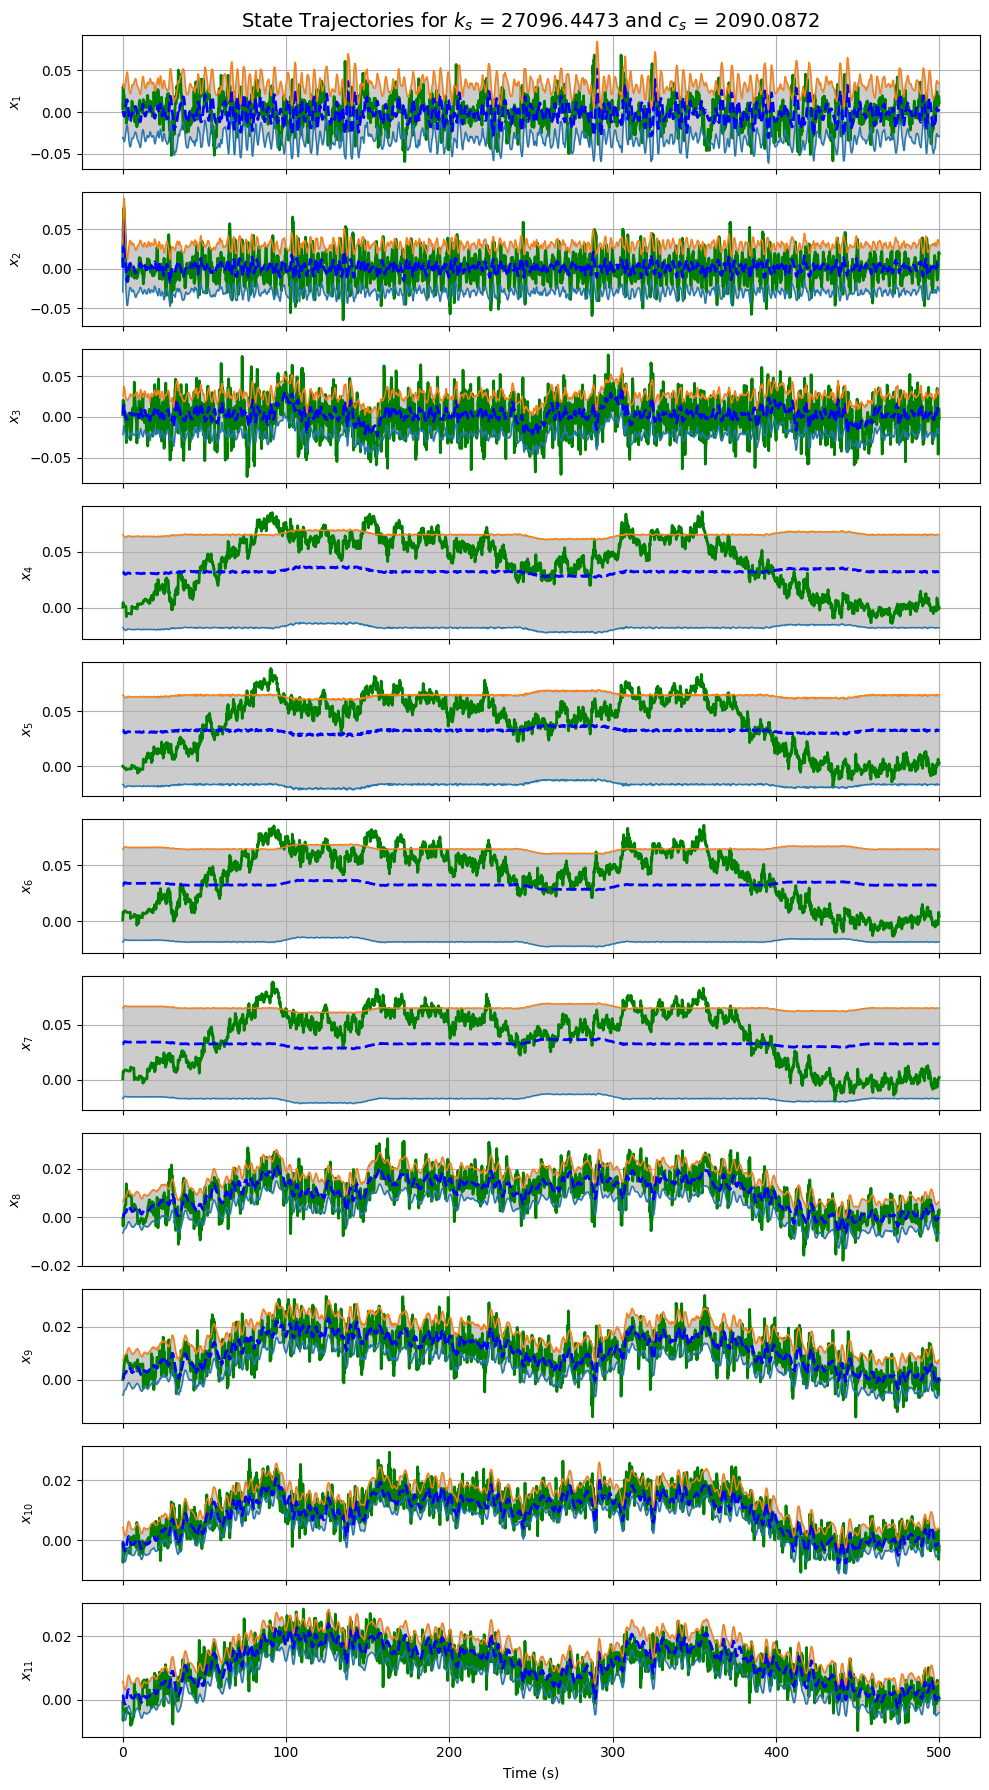

In [ ]:
# Assuming you have t, x_sys, x_sys_pred_LB, x_sys_pred, x_sys_pred_UB already defined
# Adjusting for 11 error trajectories
fig, axes = plt.subplots(11, 1, figsize=(10, 18), sharex=True)
visual_ind = slice(1, 10000)  # or just use [1001:2000] directly in indexing
for i in range(11):
    axes[i].plot(t[visual_ind], y_sys[visual_ind, i], label='system', color='g', linestyle='-', linewidth=2)
    axes[i].plot(t[visual_ind], y_sys_pred_LB[visual_ind, i], label='pred Lower', linestyle='-', linewidth=1)
    axes[i].plot(t[visual_ind], y_sys_pred[visual_ind, i], label='pred Medium', color='b', linestyle='--', linewidth=2)
    axes[i].plot(t[visual_ind], y_sys_pred_UB[visual_ind, i], label='pred Upper', linestyle='-', linewidth=1)
    axes[i].fill_between(t[visual_ind], y_sys_pred_LB[visual_ind, i], y_sys_pred_UB[visual_ind, i], color='k', alpha=0.2, label="Quantile")
    axes[i].set_ylabel(f'$x_{{{i+1}}}$')
    axes[i].grid(True)
    if i == 0:
        axes[i].set_title(f'State Trajectories for $k_s$ = {ks:.4f} and $c_s$ = {cs:.4f}', fontsize=14)
    if i == 10:
        axes[i].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

## Redefine the updated model (the original digital model + trained discrepancy function)
In this section, we need to update the model by adding the trained discrepancy function to the digital model.

In [ ]:
class DynamicSystemEnv2(gym.Env):
    def __init__(self):
        # parameters
        self.params = {
            'ms': 1500.0,       # Sprung mass (kg)
            'I_theta': 2500.0,  # Pitch moment of inertia (kg*m^2)
            'I_phi': 500.0,     # Roll moment of inertia (kg*m^2)
            'mu': [50.0, 50.0, 50.0, 50.0], # Unsprung masses for each wheel (kg)
            'ks': 25000.0,      # Suspension stiffness (N/m)
            'cs': 2000.0,       # Suspension damping (N*s/m)
            'kt': [200000.0,200000.0,200000.0,200000.0],     # Tire stiffness (N/m)
            'ct': 150.0,        # Tire damping (N*s/m)
            'lf': 1.35,         # Distance from CG to front axle (m)
            'lr': 1.35,         # Distance from CG to rear axle (m)
            'tf': 0.75,         # Half-track width of front axle (m)
            'tr': 0.75,         # Half-track width of rear axle (m)
            'h_cg': 0.55   # height of the CG above the ground (m) for a mid-size passenger vehicle
        }
        self.ks_max = 40000
        self.ks_min = 10000
        self.cs_max = 3000
        self.cs_min = 500

        self.dt = 0.01 # time step, unit: s

        # System dynamics parameters
        self.Q = np.array([[10,0,0,0], [0,1,0,0], [0,0,50,0], [0,0,0,5]])     # State cost matrix
        self.R = 0.000001                                 # Action cost
        
        # State and action spaces
        self.observation_space = spaces.Box(low=-5, high=5, shape=(14,), dtype=np.float32)
        self.action_space = spaces.Box(low=-3000, high=3000, shape=(1,), dtype=np.float32)
        
        # Initial state
        self.y_nom = np.zeros(11)
        self.state = np.zeros(14)
        self.e = np.zeros(11)
        self.y_sys_pred_LB = np.zeros(11)
        self.y_sys_pred = np.zeros(11)
        self.y_sys_pred_UB = np.zeros(11)
        
        # Maximum episode steps
        self.max_steps = 1000
        self.current_step = 0

    def step(self, action, ks_normalized, cs_normalized, ax, vx, steering_angle):

        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.params['ks'] = ks
        self.params['cs'] = cs
        y_nom = self.y_nom
        e = self.e

        # Clip action to stay within action bounds
        action = np.clip(action, self.action_space.low, self.action_space.high)
        
        # Update state based on system dynamics
        x = self.state
        y = C@x

        # Extract the previous predicted quantile-based variables (will be used in reward)
        dz_LB = self.y_sys_pred_LB[0]
        dz_MD = self.y_sys_pred[0]
        dz_UB = self.y_sys_pred_UB[0]
        dpitch_angle_LB = self.y_sys_pred_LB[1]
        dpitch_angle_MD = self.y_sys_pred[1]
        dpitch_angle_UB = self.y_sys_pred_UB[1]
        droll_angle_LB = self.y_sys_pred_LB[2]
        droll_angle_MD = self.y_sys_pred[2]
        droll_angle_UB = self.y_sys_pred_UB[2]
        zu_LB = self.y_sys_pred_LB[3:7]
        zu_MD = self.y_sys_pred[3:7]
        zu_UB = self.y_sys_pred_UB[3:7]


        # Quanntile-based Discrepancy prediction
        input_pred_model = np.concatenate((y, e, action, np.array([ax]), np.array([vx]), np.array([steering_angle])))
        e_prime_pred = model_dysys(torch.tensor(input_pred_model, dtype=torch.float32))
        e_prime_pred_numpy = e_prime_pred.detach().numpy()

        y_sys_pred_LB = y_nom + np.array([e_prime_pred_numpy[0],e_prime_pred_numpy[3],e_prime_pred_numpy[6],\
                                                    e_prime_pred_numpy[9],e_prime_pred_numpy[12],e_prime_pred_numpy[15],\
                                                        e_prime_pred_numpy[18],e_prime_pred_numpy[21],e_prime_pred_numpy[24],\
                                                            e_prime_pred_numpy[27],e_prime_pred_numpy[30]])
        y_sys_pred = y_nom + np.array([e_prime_pred_numpy[1],e_prime_pred_numpy[4],e_prime_pred_numpy[7],\
                                                e_prime_pred_numpy[10],e_prime_pred_numpy[13],e_prime_pred_numpy[16],\
                                                    e_prime_pred_numpy[19],e_prime_pred_numpy[22],e_prime_pred_numpy[25],\
                                                        e_prime_pred_numpy[28],e_prime_pred_numpy[31]])
        y_sys_pred_UB = y_nom + np.array([e_prime_pred_numpy[2],e_prime_pred_numpy[5],e_prime_pred_numpy[8],\
                                                    e_prime_pred_numpy[11],e_prime_pred_numpy[14],e_prime_pred_numpy[17],\
                                                        e_prime_pred_numpy[20],e_prime_pred_numpy[23],e_prime_pred_numpy[26],\
                                                            e_prime_pred_numpy[29],e_prime_pred_numpy[32]])
        # Current error
        self.e = np.array([e_prime_pred_numpy[1],e_prime_pred_numpy[4],e_prime_pred_numpy[7],\
            e_prime_pred_numpy[10],e_prime_pred_numpy[13],e_prime_pred_numpy[16],\
                e_prime_pred_numpy[19],e_prime_pred_numpy[22],e_prime_pred_numpy[25],\
                    e_prime_pred_numpy[28],e_prime_pred_numpy[31]])
        
        # Save predicted y
        self.y_sys_pred_LB = y_sys_pred_LB
        self.y_sys_pred = y_sys_pred
        self.y_sys_pred_UB = y_sys_pred_UB

        # Nominal prediction
        s_prime_nom = step_rk4_real(x, action, self.params, self.dt, ax, vx, steering_angle, np.zeros(4), np.zeros(4))
        x_next = s_prime_nom
        y_nom = C@s_prime_nom
        self.y_nom = y_nom

        # New predicted y
        dz_LB_next = y_sys_pred_LB[0]
        dz_MD_next = y_sys_pred[0]
        dz_UB_next = y_sys_pred_UB[0]
        dpitch_angle_LB_next = y_sys_pred_LB[1]
        dpitch_angle_MD_next = y_sys_pred[1]
        dpitch_angle_UB_next = y_sys_pred_UB[1]
        droll_angle_LB_next = y_sys_pred_LB[2]
        droll_angle_MD_next = y_sys_pred[2]
        droll_angle_UB_next = y_sys_pred_UB[2]
        zu_LB_next = y_sys_pred_LB[3:7]
        zu_MD_next = y_sys_pred[3:7]
        zu_UB_next = y_sys_pred_UB[3:7]

        # Quantile-based variables for reward
        ddz_quantile = np.array([(dz_LB_next-dz_LB)/self.dt,(dz_MD_next-dz_MD)/self.dt,(dz_UB_next-dz_UB)/self.dt])
        zs_quantile = np.array([(dz_LB_next+dz_LB)*self.dt/2,(dz_MD_next+dz_MD)*self.dt/2,(dz_UB_next+dz_UB)*self.dt/2])
        ddpitch_quantile = np.array([(dpitch_angle_LB_next-dpitch_angle_LB)/self.dt,(dpitch_angle_MD_next-dpitch_angle_MD)/self.dt,(dpitch_angle_UB_next-dpitch_angle_UB)/self.dt])
        pitch_quantile = np.array([(dpitch_angle_LB_next+dpitch_angle_LB)*self.dt/2,(dpitch_angle_MD_next+dpitch_angle_MD)*self.dt/2,(dpitch_angle_UB_next+dpitch_angle_UB)*self.dt/2])
        ddroll_quantile = np.array([(droll_angle_LB_next-droll_angle_LB)/self.dt,(droll_angle_MD_next-droll_angle_MD)/self.dt,(droll_angle_UB_next-droll_angle_UB)/self.dt])
        roll_angle_quantile = np.array([(droll_angle_LB_next+droll_angle_LB)*self.dt/2,(droll_angle_MD_next+droll_angle_MD)*self.dt/2,(droll_angle_UB_next+droll_angle_UB)*self.dt/2])

        # Quantile-based variables for state
        dzu_LB_next = (zu_LB_next-zu_LB)/self.dt
        dzu_MD_next = (zu_MD_next-zu_MD)/self.dt
        dzu_UB_next = (zu_UB_next-zu_UB)/self.dt

        # Assuming x = [z_s, theta, phi, z_u1, z_u2, z_u3, z_u4, ..., z_s_dot, theta_dot, ...]
        zs = zs_quantile[1]
        pitch_angle = pitch_quantile[1]
        Delta_pitch_angle = pitch_quantile[2]-pitch_quantile[0]
        roll_angle = roll_angle_quantile[1]
        Delta_roll_angle = roll_angle_quantile[2]-roll_angle_quantile[0]
        zu1 = zu_MD_next[0]
        zu2 = zu_MD_next[1]
        zu3 = zu_MD_next[2]
        zu4 = zu_MD_next[3]
        dzs = y_sys_pred[0]
        pitch_vel = y_sys_pred[1]
        roll_vel = y_sys_pred[2]
        dzu1 = dzu_MD_next[0]
        dzu2 = dzu_MD_next[1]
        dzu3 = dzu_MD_next[2]
        dzu4 = dzu_MD_next[3]
        
        az = ddz_quantile[1]
        Delta_az = ddz_quantile[2]-ddz_quantile[0]
        pitch_acc = ddpitch_quantile[1]
        Delta_pitch_acc = ddpitch_quantile[2]-ddpitch_quantile[0]
        roll_acc = ddroll_quantile[1]
        Delta_roll_acc = ddroll_quantile[2]-ddroll_quantile[0]

        # --- Comfort Index ---
        # Assume r_pitch = 1.0 m (longitude distance from CG)
        # Assume r_pitch = 0.5 m (latitude distance from CG)
        comfort_index = np.sqrt((10.0*az)**2 + (1.0*pitch_acc)**2 + (0.5*roll_acc)**2)
        comfort_uncertainty = np.sqrt((10.0*Delta_az)**2 + (1.0*Delta_pitch_acc)**2 + (0.5*Delta_roll_acc)**2)

        # --- Handling Metrics ---
        pitch_penalty = pitch_angle**2           # squared pitch angle
        roll_penalty = roll_angle**2             # squared roll angle
        pitch_penalty_uncertainty = Delta_pitch_angle**2
        roll_penalty_uncertainty = Delta_roll_angle**2

        # Define reward as negative of weighted sum of penalties
        reward = -(
            comfort_index +
            pitch_penalty/0.00004 +
            roll_penalty/0.00003 +
            self.R * np.sum(action**2)/0.01)\
            -0.1*(comfort_uncertainty +
            pitch_penalty_uncertainty/0.00004 +
            roll_penalty_uncertainty/0.00003)
                
        # Update state
        self.state = x_next
        # self.state = np.array([zs,pitch_angle,roll_angle,zu1,zu2,zu3,zu4,dzs,pitch_vel,roll_vel,dzu1,dzu2,dzu3,dzu4])
        
        # Check if done
        done = (self.current_step >= self.max_steps)
        self.current_step += 1
        
        return self.state, reward, done, {}
    
    def reset(self,ks_normalized,cs_normalized):
        # Reset state to initial value
        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.params['ks'] = ks
        self.params['cs'] = cs
        self.state = np.zeros(14)
        # self.state[3] = -0.1
        self.current_step = 0
        return self.state
    
    def render(self, mode='human'):
        pass

    def close(self):
        pass

In [ ]:
env2 = DynamicSystemEnv2()

Test the redefined system

In [ ]:
# import copy
ks_1 = copy.deepcopy(ks) # after the first CCD optimization
cs_1 = copy.deepcopy(cs) # after the first CCD optimization
ks_normalized = (ks-env_real.ks_min)/(env_real.ks_max-env_real.ks_min)
cs_normalized = (cs-env_real.cs_min)/(env_real.cs_max-env_real.cs_min)

print_interval = 10
N_total = 120000
print_interval = 10
s = env2.reset(ks_normalized, cs_normalized)
done = False
count = 0
x_sys = np.zeros((N_total+1,14))
y_sys = np.zeros((N_total+1,11))
a_sys = np.zeros((N_total,4))

x_sys[0,:] = np.array([s[0],s[1],s[2],s[3],s[4],s[5],s[6],s[7],s[8],s[9],s[10],s[11],s[12],s[13]])
y = C@s
y_sys[0,:] = np.array([y[0],y[1],y[2],y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10]])

model.data = []
while count < N_total:
    y = C@s
    y_tmp = np.append(cs,y)
    y_tmp = np.append(ks,y_tmp)
    y_normalized = (y - lower_bounds_y[2:]) / (upper_bounds_y[2:] - lower_bounds_y[2:]) # only observed states
    x = (y_tmp - lower_bounds_y) / (upper_bounds_y - lower_bounds_y) # all input (ks,cs,y1,...,y11)
    normalized_inputs_tmp = torch.tensor(x.reshape(1,13), dtype=torch.float32)
    # print(normalized_inputs_tmp)
    mu, std = model.pi(normalized_inputs_tmp)
    dist = Normal(mu, std)
    a = dist.sample()
    log_prob = dist.log_prob(a)
    action_tmp = a.cpu().detach().numpy().flatten()*3000
    action = np.clip(action_tmp, env_real.action_space.low, env_real.action_space.high)
    vx = vx_data[count]
    ax = ax_data[count]
    steering_angle = steering_data[count]
    s_prime, r, done, _ = env2.step(action,ks_normalized,cs_normalized,ax,vx,steering_angle)
    y_prime = C@s_prime
    y_prime_normalized = (y_prime - lower_bounds_y[2:]) / (upper_bounds_y[2:] - lower_bounds_y[2:])

    s = s_prime

    x_sys[count+1,:] = s_prime
    y_sys[count+1,:] = y_prime
    a_sys[count,:] = action
    score += r
    count += 1

env2.close()

# Second CCD

In [ ]:
ks = copy.deepcopy(ks_1) # after the first CCD optimization
cs = copy.deepcopy(cs_1) # after the first CCD optimization
model2 = copy.deepcopy(model) # save the model (for back up)
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)
print_interval = 1
rollout = []
N_total = 6000
score_total = 0.0
score_history = []
ks_history = []
cs_history = []
patience = 100
threshold = 0.01  # Minimum improvement considered significant
best_reward = -float('inf')  # Initialize best reward
no_improvement_count = 0  # Counter for no improvement
print("Starting at ks = {:.4f}, cs = {:.4f}".format(ks, cs))
for n_epi in range(3000):
    s = env2.reset(ks_normalized,cs_normalized)
    # print("ks = {:.4f}, cs = {:.4f}".format(ks, cs))
    done = False
    count = 0
    score = 0.0
    while count < N_total:
        for t in range(rollout_len):
            y = C@s
            y_tmp = np.append(cs,y)
            y_tmp = np.append(ks,y_tmp)
            y_normalized = (y - lower_bounds_y[2:]) / (upper_bounds_y[2:] - lower_bounds_y[2:]) # only observed states
            x = (y_tmp - lower_bounds_y) / (upper_bounds_y - lower_bounds_y) # all input (ks,cs,y1,...,y11)
            normalized_inputs_tmp = torch.tensor(x.reshape(1,13), dtype=torch.float32)
            # print(normalized_inputs_tmp)
            mu, std = model2.pi(normalized_inputs_tmp)
            dist = Normal(mu, std)
            a = dist.sample()
            log_prob = dist.log_prob(a)
            action_tmp = a.cpu().detach().numpy().flatten()*3000
            action = np.clip(action_tmp, env.action_space.low, env.action_space.high)
            vx = vx_data[count]
            ax = ax_data[count]
            steering_angle = steering_data[count]
            s_prime, r, done, _ = env2.step(action,ks_normalized,cs_normalized,ax,vx,steering_angle)
            y_prime = C@s_prime
            # print("State: {}, Action = {}, Next State = {}".format(y, action, y_prime))
            y_prime_normalized = (y_prime - lower_bounds_y[2:]) / (upper_bounds_y[2:] - lower_bounds_y[2:])
            rollout.append((y, action/3000, r/1000.0, y_prime, log_prob.cpu().detach().numpy().flatten(), done))
            if len(rollout) == rollout_len:
                model2.put_data(rollout)
                rollout = []

            s = s_prime

            score += r
            count += 1

        ks_torch_new, cs_torch_new = model2.train_net_CCD(ks,cs)
        ks_normalized_ccd = ks_torch_new.item()
        cs_normalized_ccd = cs_torch_new.item()
        
        ks = ks_normalized_ccd*(env2.ks_max-env2.ks_min) + env2.ks_min
        cs = cs_normalized_ccd*(env2.cs_max-env2.cs_min) + env2.cs_min
        
        ks_normalized = (ks-env2.ks_min)/(env2.ks_max-env2.ks_min)
        cs_normalized = (cs-env2.cs_min)/(env2.cs_max-env2.cs_min)

    score_total = score_total+score
    score_history.append([n_epi,score])
    ks_history.append([n_epi,ks])
    cs_history.append([n_epi,cs])

    print("# of episode :{}, score : {:.1f}, ks = {:.4f}, cs = {:.4f}".format(n_epi, score, ks, cs))

    if n_epi%print_interval==0 and n_epi!=0:

        # Check if we have improved
        if score > best_reward + threshold:
            best_reward = score
            no_improvement_count = 0  # Reset the counter

            # Save the best model so far
            torch.save({
                'model_state_dict': model2.state_dict(),
                'ks': ks,
                'cs': cs,
            }, 'best_policy_model.pt')
            print(f"New best model after second CCD saved at epoch {n_epi}, reward: {best_reward:.4f}")
        else:
            no_improvement_count += 1

        # Early stopping check
        if no_improvement_count >= patience:
            print(f"Early stopping triggered at epoch {n_epi} with reward {score}")
            break

env2.close()
print("The final ks2 = {:.4f}".format(ks)+', cs2 = {:.4f}'.format(cs))

model2_retrain = copy.deepcopy(model2) # save the model (for back up)

In [ ]:
# Load the saved model
checkpoint = torch.load('best_policy_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
ks = checkpoint['ks']
cs = checkpoint['cs']
model.eval()

## Save the trained policy